In [1]:
from scipy.io import wavfile

(source_fs, source_data) = wavfile.read('./data/01_source.wav')
(target_fs, target_lg_data) = wavfile.read('./data/01_gr-jump-head-lg.wav')
(target_fs, target_mg_data) = wavfile.read('./data/01_gr-jump-head-mg.wav')
(target_fs, target_hg_data) = wavfile.read('./data/01_gr-jump-head-hg.wav')


In [2]:
import pandas as pd

In [3]:
source_df = pd.DataFrame(source_data, columns=['L', 'R'])
source_df.head()

,L,R
0,1,-1
1,-5,-6
2,-11,-12
3,-18,-17
4,-24,-24


In [4]:
target_lg_df = pd.DataFrame(target_lg_data, columns=['L', 'R'])
target_lg_df.head()

,L,R
0,1,0
1,0,0
2,0,0
3,0,0
4,0,0


In [5]:
target_mg_df = pd.DataFrame(target_mg_data, columns=['L', 'R'])
target_mg_df.head()

,L,R
0,0,-1
1,0,0
2,0,-1
3,0,0
4,1,0


In [6]:
target_hg_df = pd.DataFrame(target_hg_data, columns=['L', 'R'])
target_hg_df.head()

,L,R
0,1,0
1,0,0
2,0,1
3,0,0
4,0,1


In [7]:
source_df['L'].max(), target_lg_df['L'].max(), target_mg_df['L'].max(), target_hg_df['L'].max()

(10790, 19284, 23459, 24606)

In [8]:
2 ** 15

32768

In [9]:
MAX_VALUE = 2 ** 15 - 1
MAX_VALUE

32767

In [10]:
len(source_df), len(target_lg_df), len(target_mg_df), len(target_hg_df)

(1302647, 1302647, 1302647, 1302647)

In [12]:
N_SAMPLES_IN_CHUNK = 4000

In [13]:
# END_LOC = int(len(target_df) * 0.8)
TR_END_LOC = int(N_SAMPLES_IN_CHUNK * 0.8 / 100) * 100
TR_END_LOC

3200

## IT'S MONO

In [14]:
import numpy as np

In [15]:
X_train_raw_lg = pd.Series(list(map(lambda x: [x, 1], source_df['L'][:TR_END_LOC])))
X_train_raw_mg = pd.Series(list(map(lambda x: [x, 2.2], source_df['L'][:TR_END_LOC])))
X_train_raw_hg = pd.Series(list(map(lambda x: [x, 6.4], source_df['L'][:TR_END_LOC])))

# X_train_raw = pd.Series(np.concatenate([X_train_raw_lg, X_train_raw_mg, X_train_raw_hg]))
X_train_raw_lg.head(), X_train_raw_lg.tail(), len(X_train_raw_lg)

(0      [1, 1]
 1     [-5, 1]
 2    [-11, 1]
 3    [-18, 1]
 4    [-24, 1]
 dtype: object, 3195    [-3457, 1]
 3196    [-3563, 1]
 3197    [-3678, 1]
 3198    [-3801, 1]
 3199    [-3923, 1]
 dtype: object, 3200)

In [16]:
X_test_raw_lg = pd.Series(list(map(lambda x: [x, 1], source_df['L'][TR_END_LOC:N_SAMPLES_IN_CHUNK])))
X_test_raw_mg = pd.Series(list(map(lambda x: [x, 2.2], source_df['L'][TR_END_LOC:N_SAMPLES_IN_CHUNK])))
X_test_raw_hg = pd.Series(list(map(lambda x: [x, 6.4], source_df['L'][TR_END_LOC:N_SAMPLES_IN_CHUNK])))

# X_test_raw = pd.Series(np.concatenate([X_test_raw_lg, X_test_raw_mg, X_test_raw_hg]))
X_test_raw_lg.head(), X_test_raw_lg.tail(), len(X_test_raw_lg)

(0    [-4036, 1]
 1    [-4138, 1]
 2    [-4219, 1]
 3    [-4270, 1]
 4    [-4279, 1]
 dtype: object, 795    [2709, 1]
 796    [2807, 1]
 797    [2894, 1]
 798    [2962, 1]
 799    [3005, 1]
 dtype: object, 800)

In [142]:
y_train_raw = np.concatenate([
    target_lg_df['L'][:TR_END_LOC],
    target_mg_df['L'][:TR_END_LOC],
    target_hg_df['L'][:TR_END_LOC]
])

len(y_train_raw)

105600

In [143]:
y_test_raw = np.concatenate([
    target_lg_df['L'][TR_END_LOC:N_SAMPLES_IN_CHUNK],
    target_mg_df['L'][TR_END_LOC:N_SAMPLES_IN_CHUNK],
    target_hg_df['L'][TR_END_LOC:N_SAMPLES_IN_CHUNK]
])

len(y_test_raw)

26400

In [144]:
X_test_raw.iloc[:10]

0    [-2139, 1]
1    [-2377, 1]
2    [-2568, 1]
3    [-2707, 1]
4    [-2792, 1]
5    [-2826, 1]
6    [-2816, 1]
7    [-2772, 1]
8    [-2702, 1]
9    [-2612, 1]
dtype: object

In [221]:
# safe-checking data

In [222]:
# y_train_raw = -y_train_raw + 4000
# y_train_raw.iloc[0]

In [223]:
# y_test_raw = -y_test_raw + 4000
# y_test_raw.iloc[0]

## Preparing data for processing

In [145]:
def normalize_keeping_mean(arr, forced_abs=None):
    left_abs = np.abs(arr.mean() - arr.min())
    right_abs = np.abs(arr.max() - arr.mean())
    
    n = max(left_abs, right_abs)
    
    if (forced_abs is not None):
        n = forced_abs
    
    return np.clip(arr / n, -1.0, 1.0)

In [146]:
def normalize(arr, forced_abs=None, mean=None):
    left_abs = np.abs(arr.mean() - arr.min())
    right_abs = np.abs(arr.max() - arr.mean())
    
    n = max(left_abs, right_abs)
    
    if (forced_abs is not None):
        n = forced_abs
        
    if (mean is None):
        mean = arr.mean()
    
    
    return np.clip((arr - mean) / n, -1.0, 1.0)

In [ ]:
def norm_and_make_windows(x)

In [147]:
import numpy as np

X_tr_n = np.array(list(map(lambda x: np.array([x[0] / MAX_VALUE, x[1]]), X_train_raw)))
# X_tr_n = normalize(X_tr, forced_abs=MAX_VALUE, mean=0.0)
X_tr_n[:5], X_tr_n.min(), X_tr_n.max(), np.mean(X_tr_n)

(array([[ 3.05185095e-05,  1.00000000e+00],
        [-1.52592547e-04,  1.00000000e+00],
        [-3.35703604e-04,  1.00000000e+00],
        [-5.49333171e-04,  1.00000000e+00],
        [-7.32444227e-04,  1.00000000e+00]]),
 -0.1969054231391339,
 6.4,
 1.600054102294576)

In [148]:
X_te_n = np.array(list(map(lambda x: np.array([x[0] / MAX_VALUE, x[1]]), X_test_raw)))
# X_te_n= normalize(X_te, forced_abs=MAX_VALUE, mean=0.0)
X_te_n.min(), X_te_n.max(), np.mean(X_te_n)

(-0.1718192083498642, 6.4, 1.5999425957240794)

In [149]:
y_tr = np.array(list(map(lambda x: np.array(x), y_train_raw)))
y_tr_n = normalize(y_tr, forced_abs=MAX_VALUE, mean=0.0)
y_tr_n.min(), y_tr_n.max(), np.mean(y_tr_n)

(-0.7998596148564104, 0.7509384441663869, 0.028474410056403755)

In [150]:
y_te = np.array(list(map(lambda x: np.array(x), y_test_raw)))
y_te_n = normalize(y_te, forced_abs=MAX_VALUE, mean=0.0)
y_te_n.min(), y_te_n.max(), np.mean(y_te_n)

(-0.7204809717093417, 0.7200231940672017, 0.03227417458991908)

In [151]:
X_tr_n = X_tr_n.astype('float32')
X_te_n = X_te_n.astype('float32')
y_tr_n = y_tr_n.astype('float32')
y_te_n = y_te_n.astype('float32')

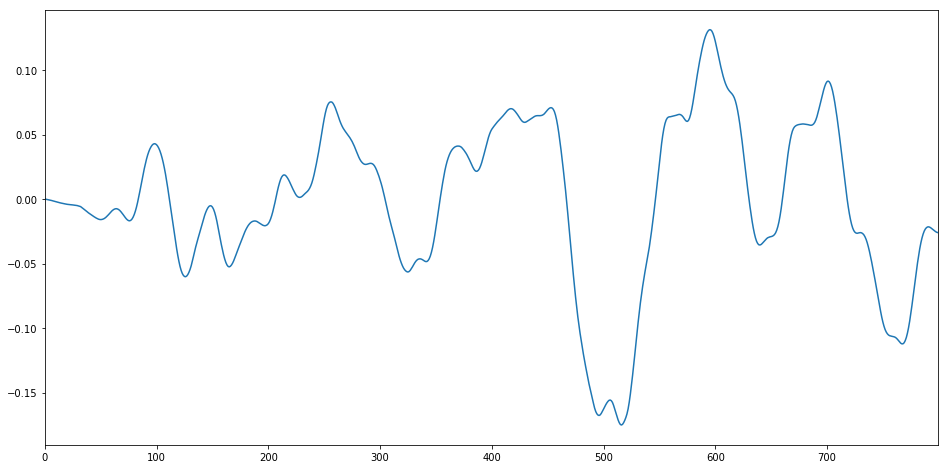

In [152]:
%matplotlib inline

pd.Series(map(lambda x: x[0], X_tr_n[:800])).plot.line(figsize=(16, 8))

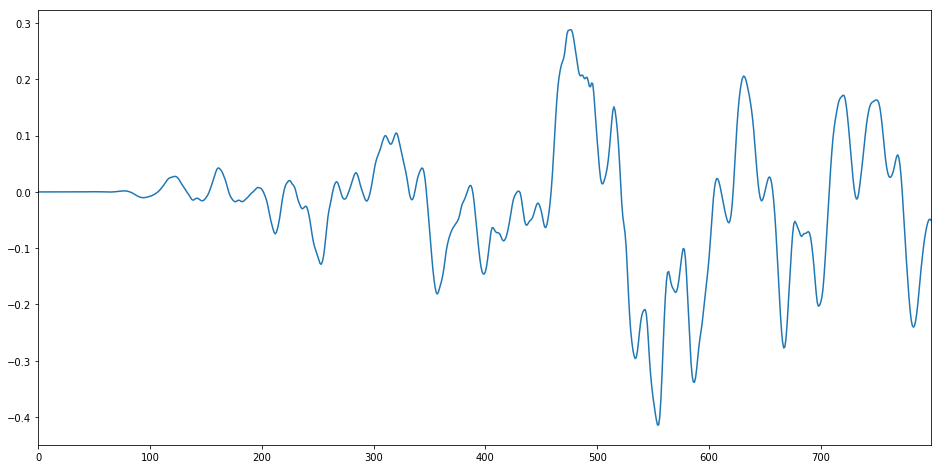

In [153]:
pd.Series(y_tr_n[:800]).plot.line(figsize=(16, 8))

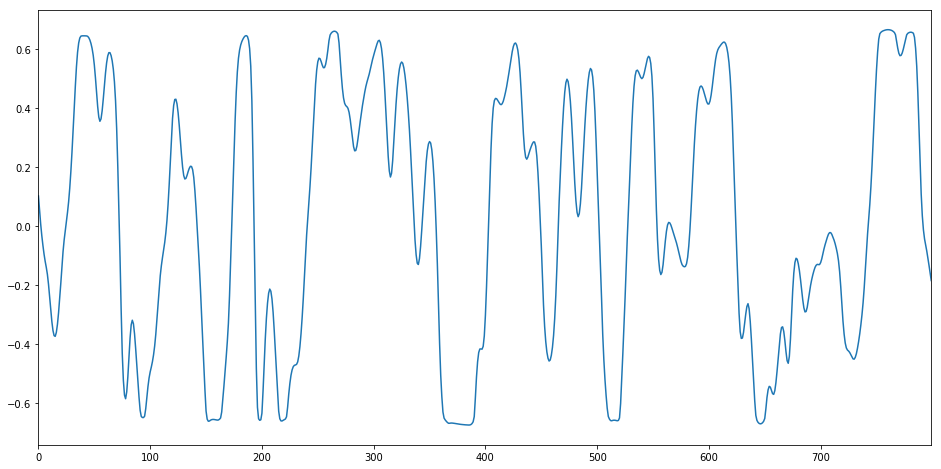

In [155]:
pd.Series(y_tr_n[N_SAMPLES_IN_CHUNK:N_SAMPLES_IN_CHUNK + 800]).plot.line(figsize=(16, 8))

In [156]:
X_te_n.min(), X_te_n.max(), np.mean(X_te_n)

(-0.17181921, 6.4, 1.5999427)

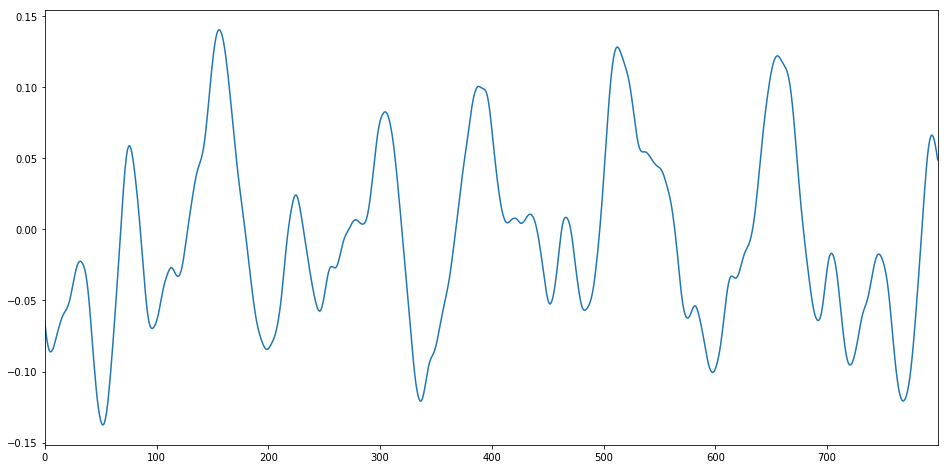

In [157]:
pd.Series(map(lambda x: x[0], X_te_n[:800])).plot.line(figsize=(16, 8))

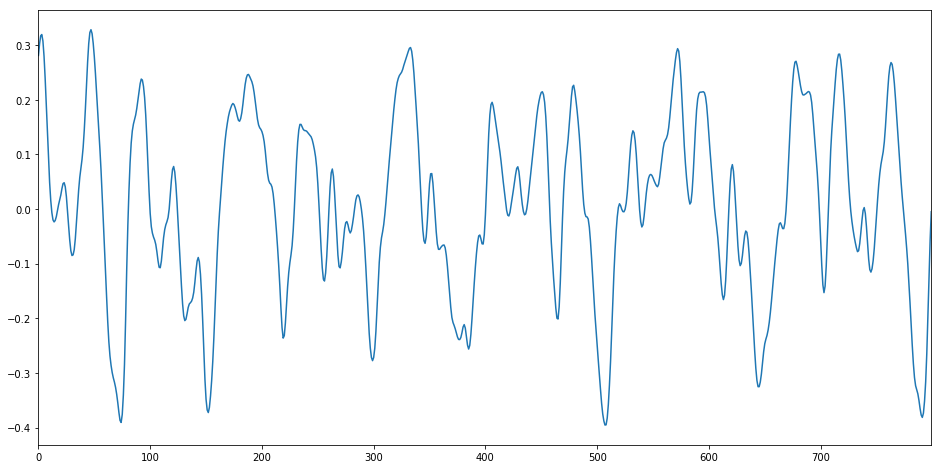

In [158]:
pd.Series(y_te_n[:800]).plot.line(figsize=(16, 8))

In [159]:
# appending stats of the whole sample, fading from silence

In [160]:
# train_shuffle_index = np.random.shuffle(np.arange(0, len(X_tr_n)))
# test_shuffle_index = np.random.shuffle(np.arange(0, len(X_te_n)))

# X_tr_f = X_tr_n[train_shuffle_index][0]
# y_tr_f = y_tr_n[train_shuffle_index][0]

# X_te_f = X_te_n[test_shuffle_index][0]
# y_te_f = y_te_n[test_shuffle_index][0]

## Making windows

In [161]:
# N_WINDOW_POINTS = int(source_clean_fs * 0.02)
N_WINDOW_POINTS = 64
N_WINDOW_POINTS

64

In [162]:
N_SAMPLES = N_SAMPLES_IN_CHUNK * 3
N_SAMPLES

132000

In [163]:
def make_windows(X, y, n_window_points):
    index = 0
    
    res_X = []
    res_y = []
    
    for index in range(0, len(X) - n_window_points - 1):
        res_X.append(X[index:(index + n_window_points)])
#         res_y.append(y.iloc[index + n_window_points])
        res_y.append(y[index + n_window_points - 1])

    return (np.array(res_X), np.array(res_y))

In [164]:
%%time
(X_tr_f, y_tr_f) = make_windows(
    X_tr_n[:(N_SAMPLES + N_WINDOW_POINTS + 1)],
    y_tr_n[:(N_SAMPLES + N_WINDOW_POINTS + 1)],
    N_WINDOW_POINTS)

print((len(X_tr_f), X_tr_f[0][:5], X_tr_f[N_SAMPLES_IN_CHUNK][:5], y_tr_f[0]))

globals().update(locals())

(105535, array([[ 3.0518509e-05,  1.0000000e+00],
       [-1.5259255e-04,  1.0000000e+00],
       [-3.3570360e-04,  1.0000000e+00],
       [-5.4933317e-04,  1.0000000e+00],
       [-7.3244423e-04,  1.0000000e+00]], dtype=float32), array([[-0.01028474,  2.2       ],
       [-0.0085757 ,  2.2       ],
       [-0.00668355,  2.2       ],
       [-0.00463881,  2.2       ],
       [-0.00234993,  2.2       ]], dtype=float32), -0.00015259255)
CPU times: user 149 ms, sys: 15.5 ms, total: 164 ms
Wall time: 163 ms


In [165]:
%%time
(X_te_f, y_te_f) = make_windows(
    X_te_n[:(N_SAMPLES + N_WINDOW_POINTS + 1)],
    y_te_n[:(N_SAMPLES + N_WINDOW_POINTS + 1)],
    N_WINDOW_POINTS
)

print((len(X_te_f), X_te_f[0][:5], X_te_f[1000][:5], y_te_f[0]))

globals().update(locals())

(26335, array([[-0.06527909,  1.        ],
       [-0.0725425 ,  1.        ],
       [-0.07837153,  1.        ],
       [-0.0826136 ,  1.        ],
       [-0.08520768,  1.        ]], dtype=float32), array([[0.00738548, 1.        ],
       [0.00903348, 1.        ],
       [0.01107822, 1.        ],
       [0.01361126, 1.        ],
       [0.0168157 , 1.        ]], dtype=float32), -0.24283578)
CPU times: user 28.9 ms, sys: 12.8 ms, total: 41.7 ms
Wall time: 40.5 ms


In [166]:
# import numpy as np

# train_shuffle_index = np.arange(0, len(X_tr_f))
# np.random.shuffle(train_shuffle_index)

# test_shuffle_index = np.arange(0, len(X_te_f))
# np.random.shuffle(test_shuffle_index)

# X_tr_f = np.array(X_tr_f)[train_shuffle_index]
# y_tr_f = np.array(y_tr_f)[train_shuffle_index]

# X_te_f = np.array(X_te_f)[test_shuffle_index]
# y_te_f = np.array(y_te_f)[test_shuffle_index]

# X_tr_f[0], y_tr_f[0], len(X_tr_f), len(y_tr_f), len(X_te_f), len(y_te_f)

In [167]:
# X_tr_f = X_tr_n
# y_tr_f = y_tr_n

# X_te_f = X_te_n
# y_te_f = y_te_n

In [168]:
(len(X_tr_f), len(y_tr_f), len(X_te_f), len(y_te_f))

(105535, 105535, 26335, 26335)

In [169]:
# list(map(lambda row: row[:N_PEAKS*2], X_tr_f))[0]
# # list(map(lambda row: row[:N_PEAKS], X_tr_f))[0]

In [170]:
# from matplotlib import pyplot as plt

# # amp_df = pd.DataFrame(list(map(lambda row: row[N_PEAKS:N_PEAKS*2], X_tr_f)))
# amp_df = pd.DataFrame(list(map(lambda row: row, X_tr_f)))

# f = plt.figure(figsize=(19, 15))
# plt.matshow(amp_df.corr())
# plt.xticks(range(amp_df.shape[1]), amp_df.columns, fontsize=14, rotation=45)
# plt.yticks(range(amp_df.shape[1]), amp_df.columns, fontsize=14)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
# plt.title('Correlation Matrix', fontsize=16);

In [171]:
n_features = 2

In [172]:
(X_tr_f[0][:5], y_tr_f[0])

(array([[ 3.0518509e-05,  1.0000000e+00],
        [-1.5259255e-04,  1.0000000e+00],
        [-3.3570360e-04,  1.0000000e+00],
        [-5.4933317e-04,  1.0000000e+00],
        [-7.3244423e-04,  1.0000000e+00]], dtype=float32), -0.00015259255)

In [173]:
X_tr_s = X_tr_f.reshape(X_tr_f.shape[0], X_tr_f.shape[1], n_features)
X_tr_s[0][:5]

array([[ 3.0518509e-05,  1.0000000e+00],
       [-1.5259255e-04,  1.0000000e+00],
       [-3.3570360e-04,  1.0000000e+00],
       [-5.4933317e-04,  1.0000000e+00],
       [-7.3244423e-04,  1.0000000e+00]], dtype=float32)

In [174]:
y_tr_s = y_tr_f

In [175]:
X_te_s = X_te_f.reshape(X_te_f.shape[0], X_te_f.shape[1], n_features)
X_te_s[0][:5]

array([[-0.06527909,  1.        ],
       [-0.0725425 ,  1.        ],
       [-0.07837153,  1.        ],
       [-0.0826136 ,  1.        ],
       [-0.08520768,  1.        ]], dtype=float32)

In [176]:
y_te_s = y_te_f

In [177]:
def add_stats(row):
    stats = [
        np.abs(row[-1]),
        -np.abs(row[-1]),
#         np.mean(row),
#         np.max(row),
#         np.min(row),
#         np.var(row)
    ]

    return np.array([(list(x) + list(stats)) for x in row])

In [178]:
# %%time
# X_tr_s = np.array([add_stats(row) for row in X_tr_s])
# print(X_tr_s[0][0], X_tr_s[0][1])

In [179]:
# %%time
# X_te_s = np.array([add_stats(row) for row in X_te_s])
# print(X_te_s[0][0], X_te_s[0][1])

In [180]:
N_REPEAT = 4
N_REPEAT

4

In [181]:
X_tr_s[0][0]

array([3.051851e-05, 1.000000e+00], dtype=float32)

In [182]:
# X_tr_s = np.repeat(X_tr_s, N_REPEAT, axis=0)
# X_tr_s[0][0], X_tr_s[1][0]

In [100]:
# y_tr_s = np.repeat(y_tr_s, N_REPEAT, axis=0)
# y_tr_s[0], y_tr_s[1]

In [101]:
# X_te_s = np.repeat(X_te_s, N_REPEAT, axis=0)
# X_te_s[0][0], X_te_s[1][0]

In [102]:
# y_te_s = np.repeat(y_te_s, N_REPEAT, axis=0)
# y_tr_s[0], y_tr_s[1]

## Finished data processing!

## Moving on to training NN

In [103]:
import numpy as np

In [104]:
# num_steps=100, 24 hidden states

In [105]:
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, Reshape, GRU, CuDNNGRU, GaussianNoise
from keras.layers import Convolution2D, MaxPooling2D, Layer, Input, BatchNormalization
from keras.utils import np_utils
from keras.regularizers import L1L2
from keras.layers.merge import concatenate

tf.set_random_seed(1234)

Using TensorFlow backend.


In [106]:
X_tr_s.shape, y_tr_s.shape, X_te_s.shape, y_te_s.shape

((4735, 64, 2), (4735,), (1135, 64, 2), (1135,))

In [107]:
y_tr_s

array([-1.5259255e-04, -1.8311106e-04, -1.5259255e-04, ...,
       -7.5515002e-01, -7.5429547e-01, -7.5368512e-01], dtype=float32)

In [108]:
from keras import backend as K
from keras.layers import Layer

class DebugLayer(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(DebugLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(DebugLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        print(x[0])
        return x

In [109]:
from scipy.signal import savgol_filter
from matplotlib import pyplot as plt


# TensorBoard callback
# tensorboard_cb = keras.callbacks.TensorBoard(
#     log_dir='./logs',
#     batch_size=BATCH_SIZE,
#     # histogram_freq='batch',
#     write_graph=True,
#     write_grads=True,
#     write_images=True
# )

class TestModel(keras.callbacks.Callback):
    def __init__(self, model, I=200, batch_size=1):
        self.model = model
        self.I = I
        self.batch_size = batch_size
        
    def on_train_begin(self, epoch_n):
        (fig, ax) = plt.subplots(figsize=(12, 8))
        I = self.I
#         (fig, ax) = plt.subplots()
        self.fig = fig
        self.ax = ax
        
        feat = pd.Series((np.array(list(map(lambda row: row[-1][0], X_tr_s[:I])))))

        feat_data, =  ax.plot(feat.values, label='feature')

        targ = (pd.Series((y_tr_s[:I])))

        pred = pd.Series(np.zeros(I))
        # pred = (pred * 2.2) + 0.001
        pred = pred + 0.001

        zeros = pd.Series(np.zeros(I))
        zeros.plot.line(ax=ax, label='0')

        targ_data, = ax.plot(targ.values, label='target')

        pred_data, = ax.plot(pred.values, label='predicted')
        # pd.Series(savgol_filter(pred, 5, 3)).plot.line(ax=ax, label='savgol(predicted)')
        
        self.feat_data = feat_data
        self.targ_data = targ_data
        self.pred_data = pred_data
        
        ax.legend(loc='upper right')
        ax.set_title('NN predictions on first {} samples'.format(I))
        ax.set_xlabel('index')
        ax.set_ylabel('value')
        
        plt.show()
        fig.canvas.draw()
        
        
    def on_epoch_end(self, epoch_n, logs={}):
        loss = logs['loss']
        model = self.model
        
        fig = self.fig
        ax = self.ax
        
        I = self.I
        batch_size = self.batch_size

        feat = pd.Series((np.array(list(map(lambda row: row[-1][0], X_tr_s[:I])))))

        self.feat_data.set_ydata(feat.values)

        targ = (pd.Series((y_tr_s[:I])))

        pred = pd.Series(predict(model, X_tr_s[:I], batch_size=batch_size))
        # pred = (pred * 2.2) + 0.001
        pred = pred + 0.001

        # zeros = pd.Series(np.zeros(I))
        # zeros.plot.line(ax=ax, label='0')

        self.targ_data.set_ydata(targ.values)

        self.pred_data.set_ydata(pred.values)
        # pd.Series(savgol_filter(pred, 5, 3)).plot.line(ax=ax, label='savgol(predicted)')

        # pd.Series(normalize(np.array(list(map(lambda w: w[-1], X_tr_f[:I]))))).plot.line(ax=ax, label='feature')

        ax.set_title('NN predictions on first {} samples, epoch {}, loss={:.4f}'.format(I, epoch_n, loss))
        
        fig.canvas.draw()


# Callback to display the target and prediciton
# test_model_cb = keras.callbacks.LambdaCallback(on_epoch_end=testmodel)

In [110]:
from keras import backend as K
    
def load_model(filepath):
    model = keras.models.load_model(filepath)
    
    return model
    
    
    
def create_model(params):
    input_L = Input(
        shape=(N_WINDOW_POINTS, n_features),
        batch_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
    )

    # bn_L = (BatchNormalization()(input_L))

    GRU_L = CuDNNGRU
    
    gru_1_L = GRU_L(
        params['n_units'],
        input_shape=(N_WINDOW_POINTS, n_features),
        batch_input_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
#         bias_regularizer=L1L2(l1=0.01, l2=0.01),
#         recurrent_regularizer=L1L2(l1=0.01, l2=0.01),
        stateful=True,
        # reset_after=True,
        # batch_input_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
#         activation='tanh',
#         recurrent_activation='hard_sigmoid',
        # kernel_initializer=keras.initializers.RandomNormal(stddev=0.1),
        kernel_initializer=keras.initializers.glorot_uniform(seed=43),
#         recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=42),
        recurrent_initializer=keras.initializers.glorot_uniform(seed=43),
        # kernel_initializer='identity',
        bias_initializer='zeros',
        return_sequences=True,
    )(input_L)

    gru_2_L = GRU_L(
        params['n_units'],
        input_shape=(N_WINDOW_POINTS, n_features),
        batch_input_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
#         bias_regularizer=L1L2(l1=0.01, l2=0.01),
#         recurrent_regularizer=L1L2(l1=0.01, l2=0.01),
        stateful=True,
        # reset_after=True,
        # batch_input_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
#         activation='tanh',
#         recurrent_activation='hard_sigmoid',
        # kernel_initializer=keras.initializers.RandomNormal(stddev=0.1),
        kernel_initializer=keras.initializers.glorot_uniform(seed=43),
#         recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=42),
        recurrent_initializer=keras.initializers.glorot_uniform(seed=43),
        # kernel_initializer='identity',
        bias_initializer='zeros',
    #     return_sequences=True,
    )(gru_1_L)

    dense_2_l = Dense(
        1,
        activation=None,
        kernel_initializer='identity',
        bias_initializer='zeros',
    # )(gru_1_l)
    )(gru_2_L)


    model = Model(inputs=input_L, outputs=dense_2_l)
    
    return model

    

def train_model(model, X_tr, y_tr, x_val, y_val, params, verbose_fit=0):
    print(params)
    
    optimizer = keras.optimizers.adam(lr=params['lr'], clipvalue=10, clipnorm=10)
    # optimizer = keras.optimizers.SGD(lr=params['lr'], decay=0.2)


    def mean_squared_error(y_true, y_pred):
        return K.mean(K.square(10 * (y_pred - y_true)), axis=-1)

    # model.compile(optimizer=optimizer, loss='mse')
    model.compile(optimizer=optimizer, loss='mae')
    
    # TRAIN

    es_cb = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.0005,
        patience=8,
        verbose=0,
        mode='auto',
    )

    def step_decay(epoch):
        initial_lrate = params['lr']
        drop = 0.8
        epochs_drop = 40.0
        lrate = initial_lrate * math.pow(drop,  
               math.floor((1+epoch)/epochs_drop))
        return lrate

    lrate = keras.callbacks.LearningRateScheduler(step_decay)

    test_model_cb = TestModel(model, I=min(params['n_samples'], 2000), batch_size=params['batch_size'])

    history = model.fit(
        X_tr_s[:params['n_samples']],
        y_tr_s[:params['n_samples']],
#         X_tr_s[:40],
#         y_tr_s[:40],
        batch_size=params['batch_size'],
        shuffle=False,
    #     epochs=400,
#         epochs=100,
        epochs=params['epochs'],
        verbose=verbose_fit,
#         validation_data=(X_te_s[:1000], y_te_s[:1000]),
        # validation_data=(X_te_s[:200], y_te_s[:200]),
        # callbacks=[es_cb, test_model_cb, tensorboard_cb],
        callbacks=[es_cb, test_model_cb, lrate],
    )
    
    return (history, model)


def create_and_train_model(X_tr, y_tr, x_val, y_val, params):
    model = create_model(params)

    (history, model) = train_model(
        model,
        X_tr_s,
        y_tr_s,
        X_te_s,
        y_te_s,
#         X_tr_s[:params['n_samples']],
#         y_tr_s[:params['n_samples']],
#         X_te_s[:params['n_samples']],
#         y_te_s[:params['n_samples']],
        params
    )
    
    return (history, model)

In [111]:
import math

def predict(model, X_input, batch_size=1, verbose=0):
    # X_input = np.array(rows).reshape(rows.shape[0], rows.shape[1], n_features)
    
    return np.array(
        model.predict(
            X_input[:(math.floor(len(X_input) / batch_size) * batch_size)],
            batch_size=batch_size,
            verbose=verbose,
        )
    ).flatten()


  0%|          | 0/9 [00:00<?, ?it/s]

{'batch_size': 100, 'epochs': 100, 'lr': 0.001, 'n_samples': 4700, 'n_units': 16, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


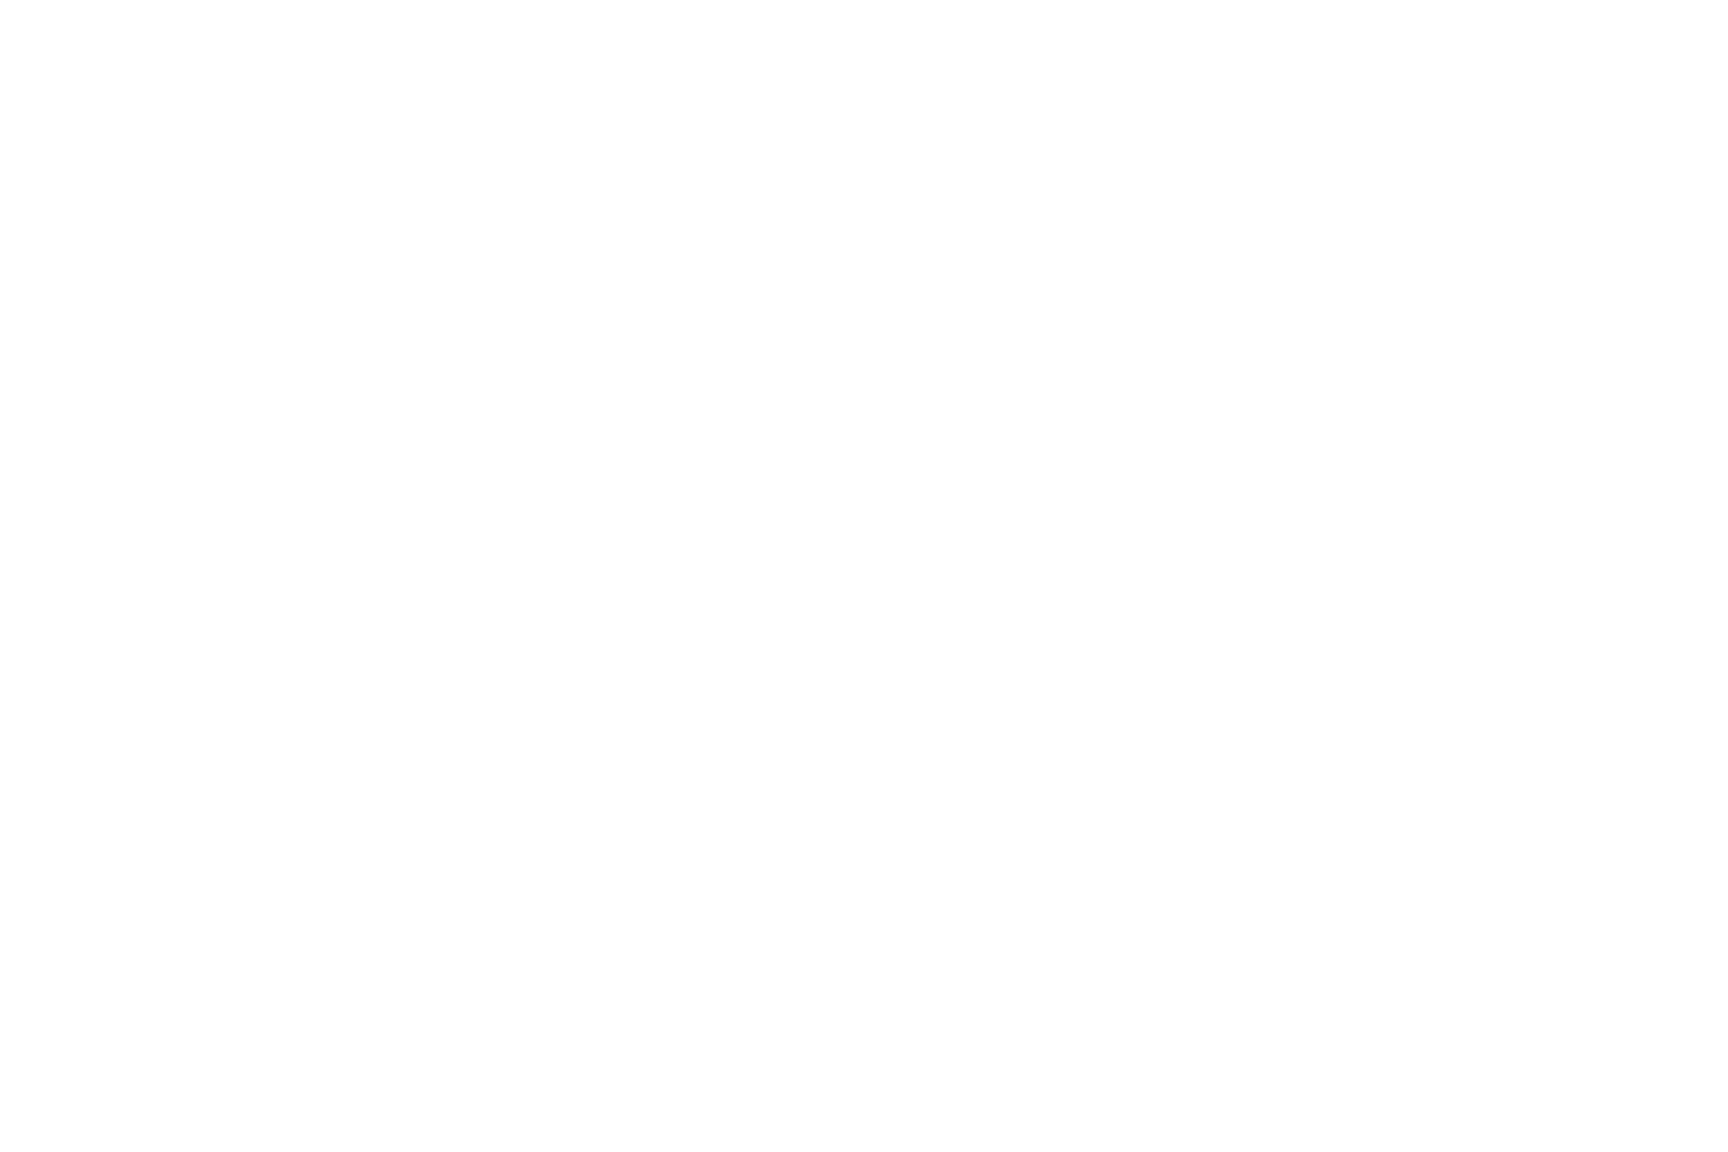


 11%|█         | 1/9 [00:53<07:10, 53.79s/it]

{'batch_size': 100, 'epochs': 100, 'lr': 0.001, 'n_samples': 4700, 'n_units': 20, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


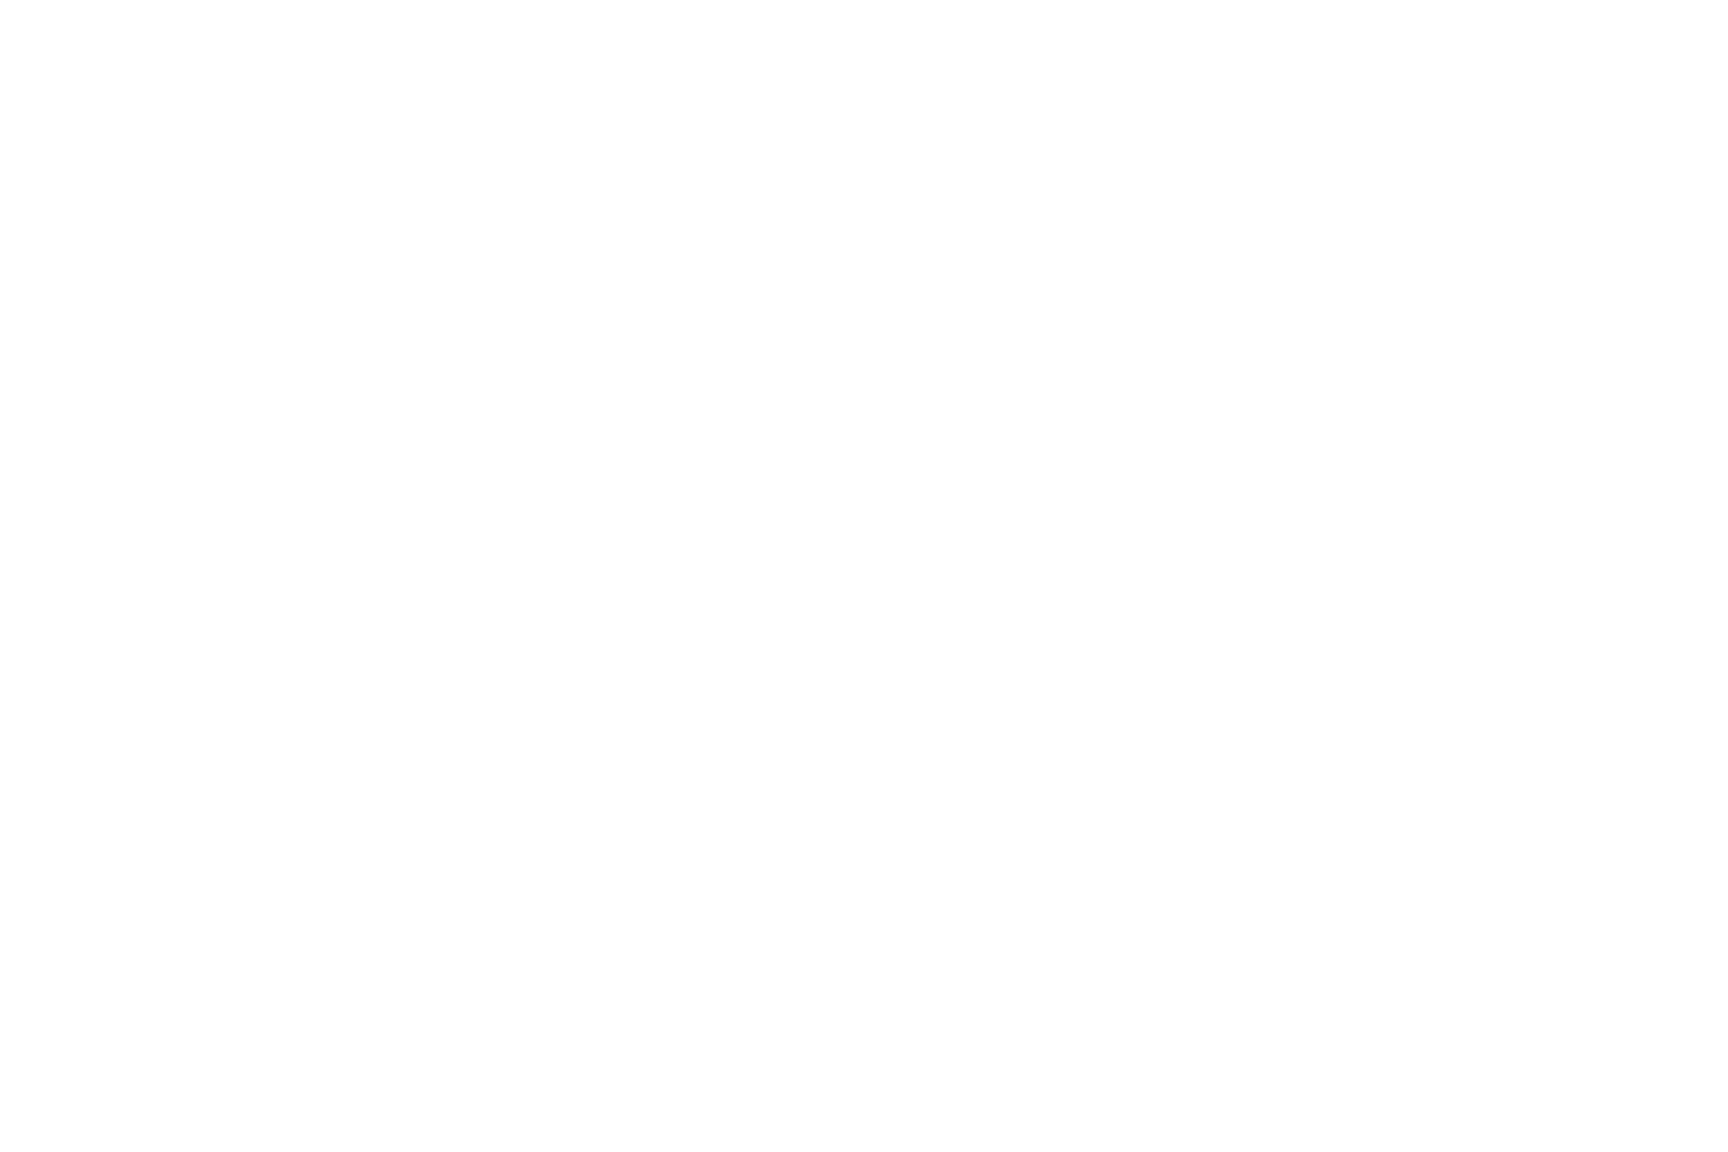


 22%|██▏       | 2/9 [01:48<06:18, 54.10s/it]

{'batch_size': 100, 'epochs': 100, 'lr': 0.001, 'n_samples': 4700, 'n_units': 24, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


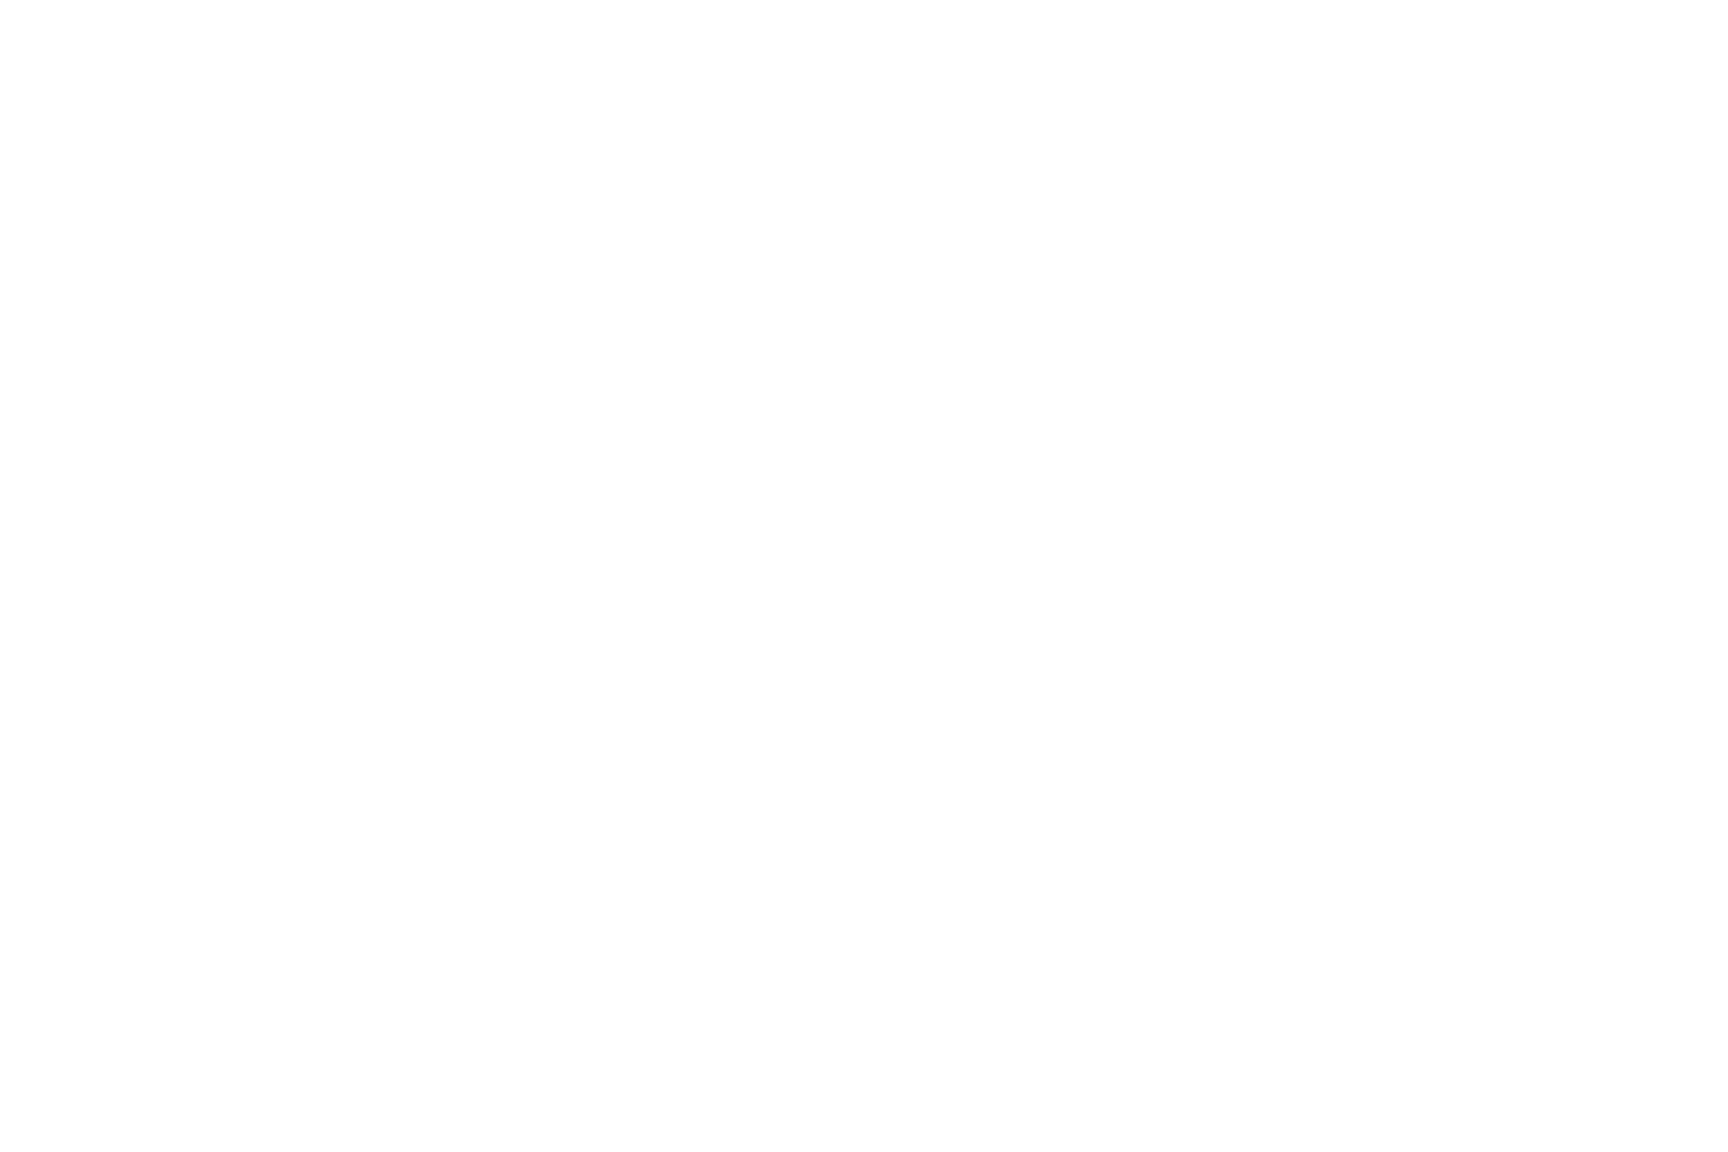


 33%|███▎      | 3/9 [02:43<05:25, 54.22s/it]

{'batch_size': 100, 'epochs': 100, 'lr': 0.002, 'n_samples': 4700, 'n_units': 16, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


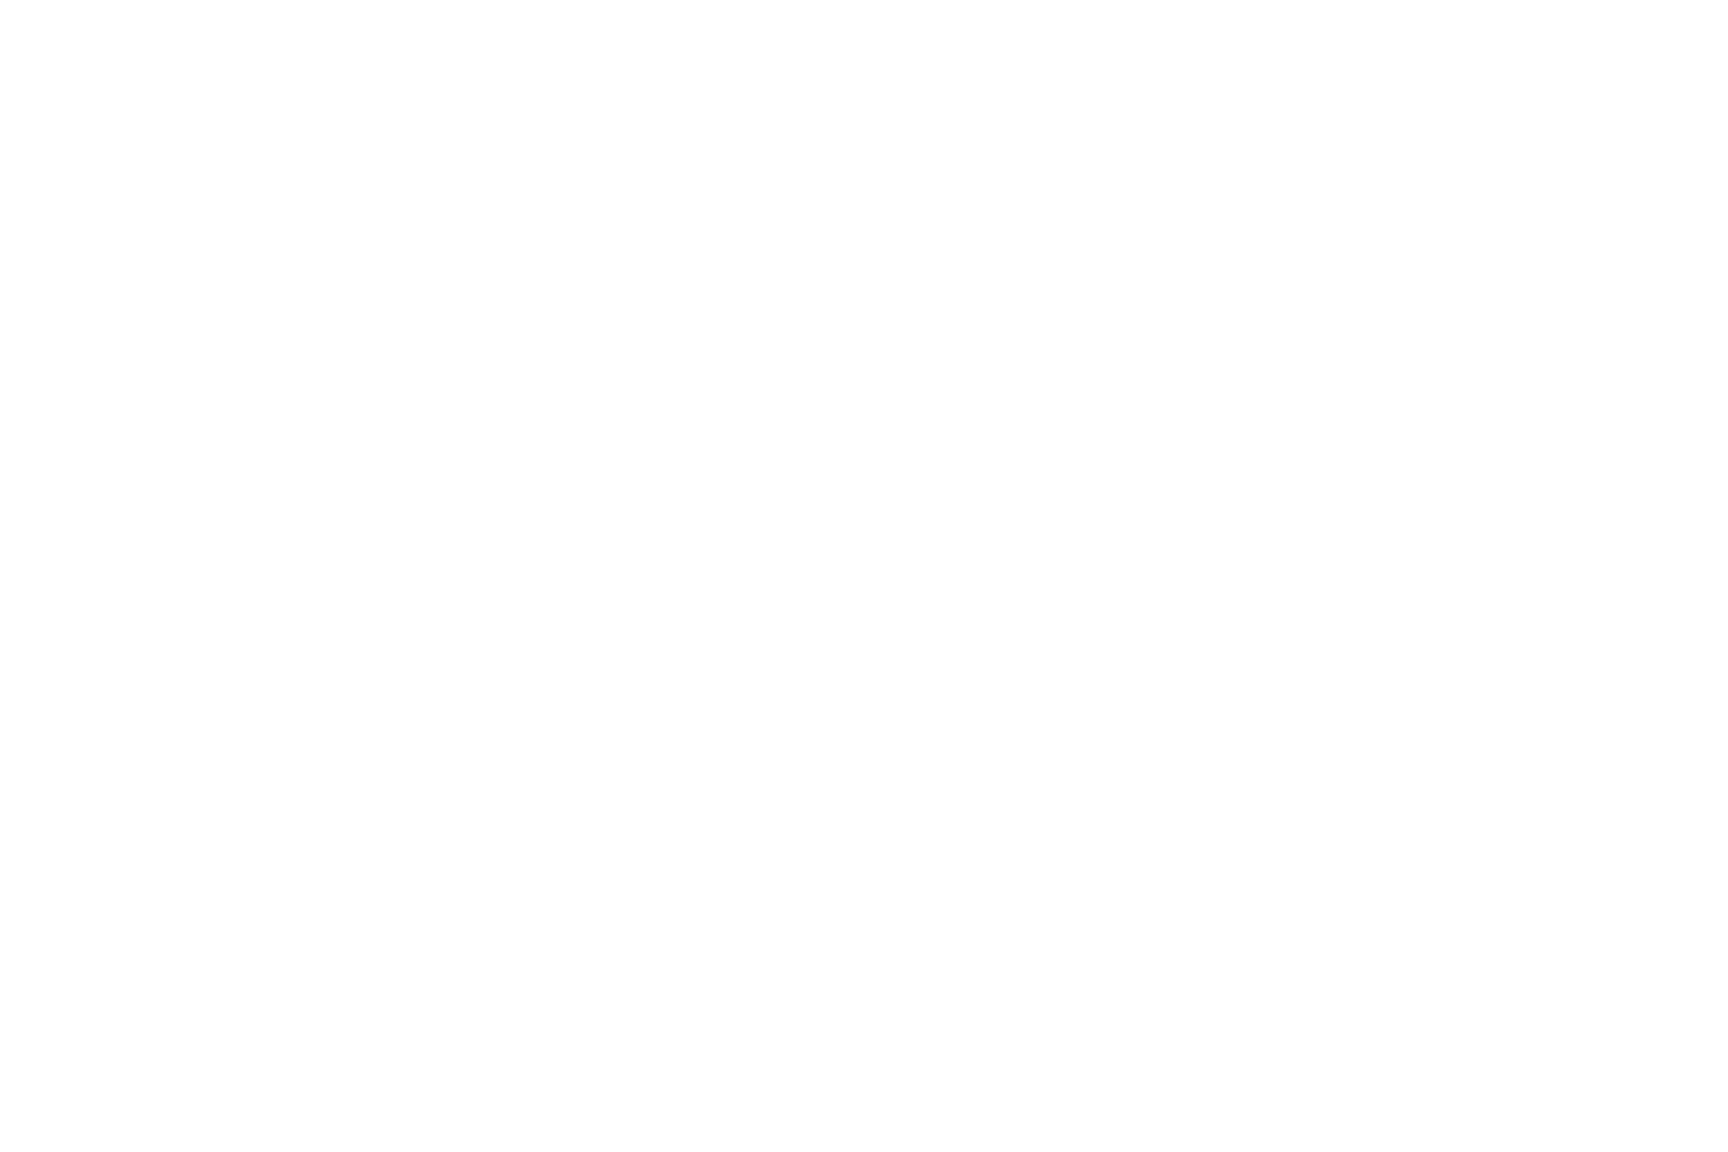


 44%|████▍     | 4/9 [03:36<04:29, 53.98s/it]

{'batch_size': 100, 'epochs': 100, 'lr': 0.002, 'n_samples': 4700, 'n_units': 20, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


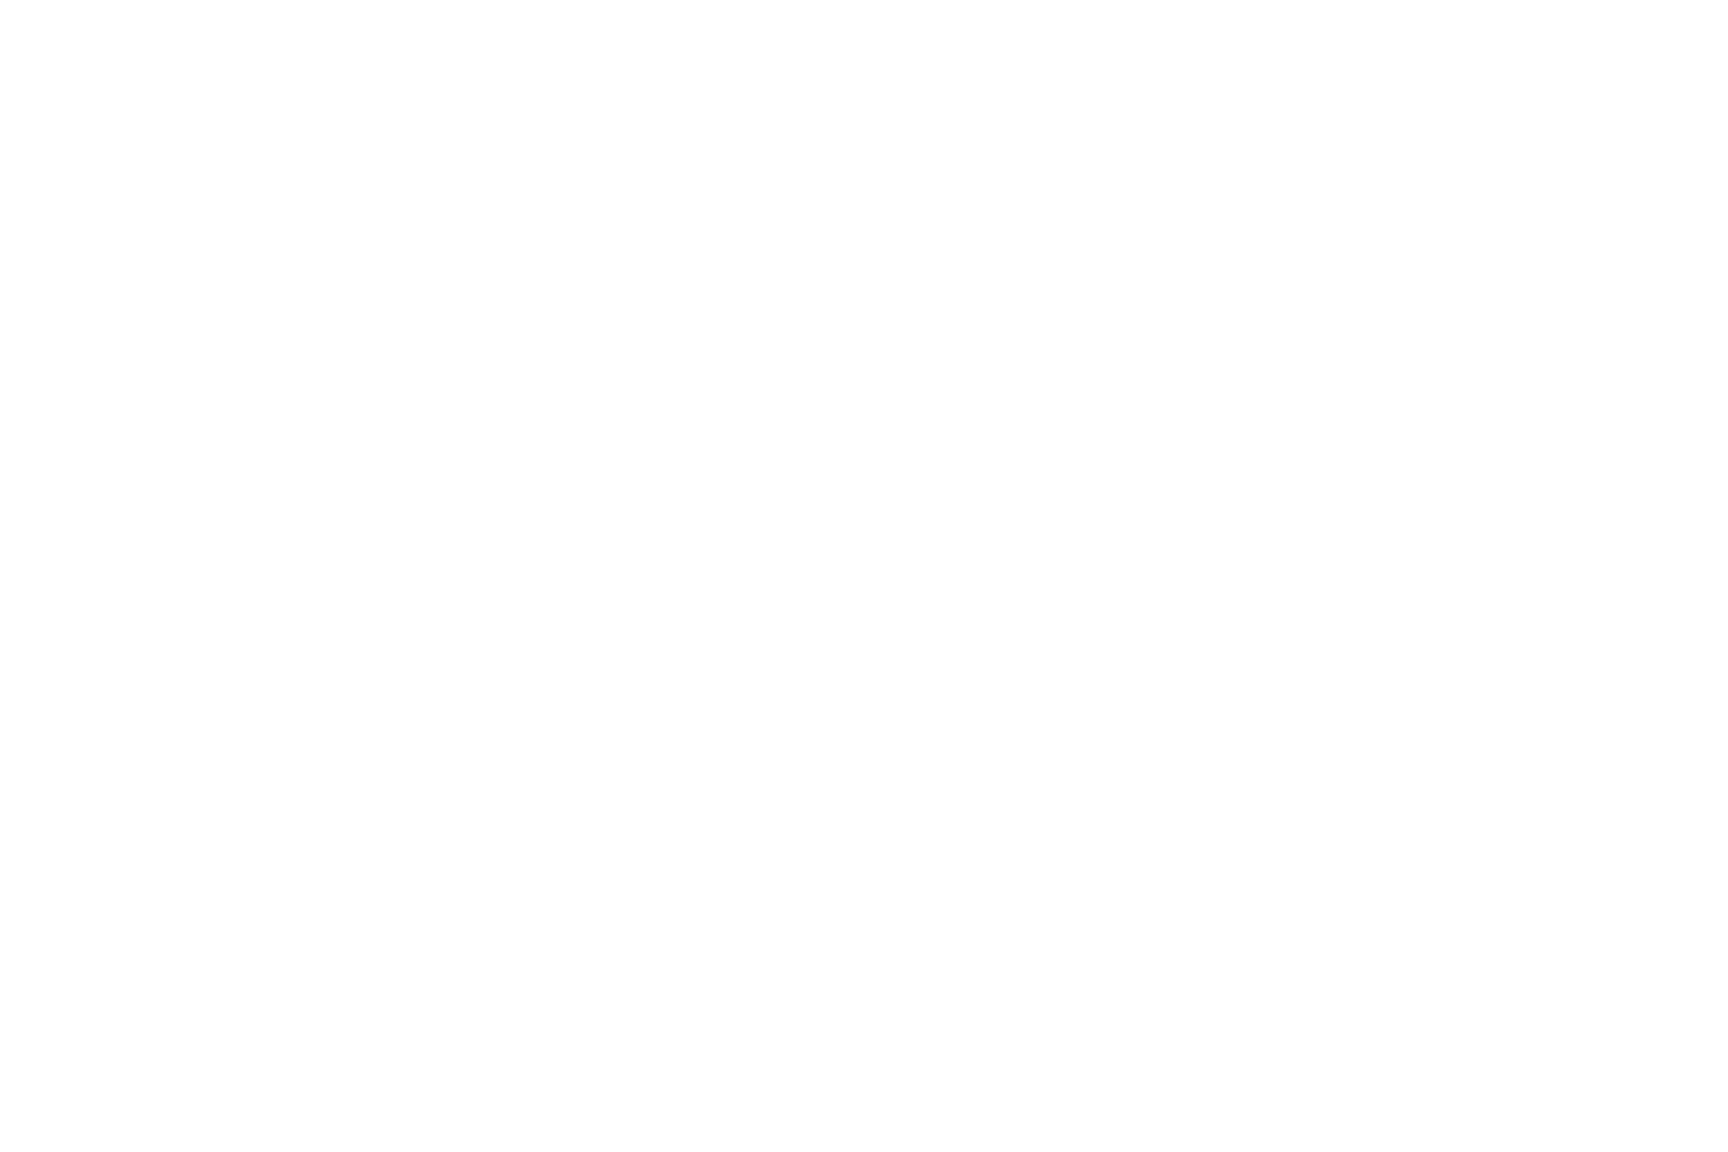


 56%|█████▌    | 5/9 [04:31<03:37, 54.28s/it]

{'batch_size': 100, 'epochs': 100, 'lr': 0.002, 'n_samples': 4700, 'n_units': 24, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


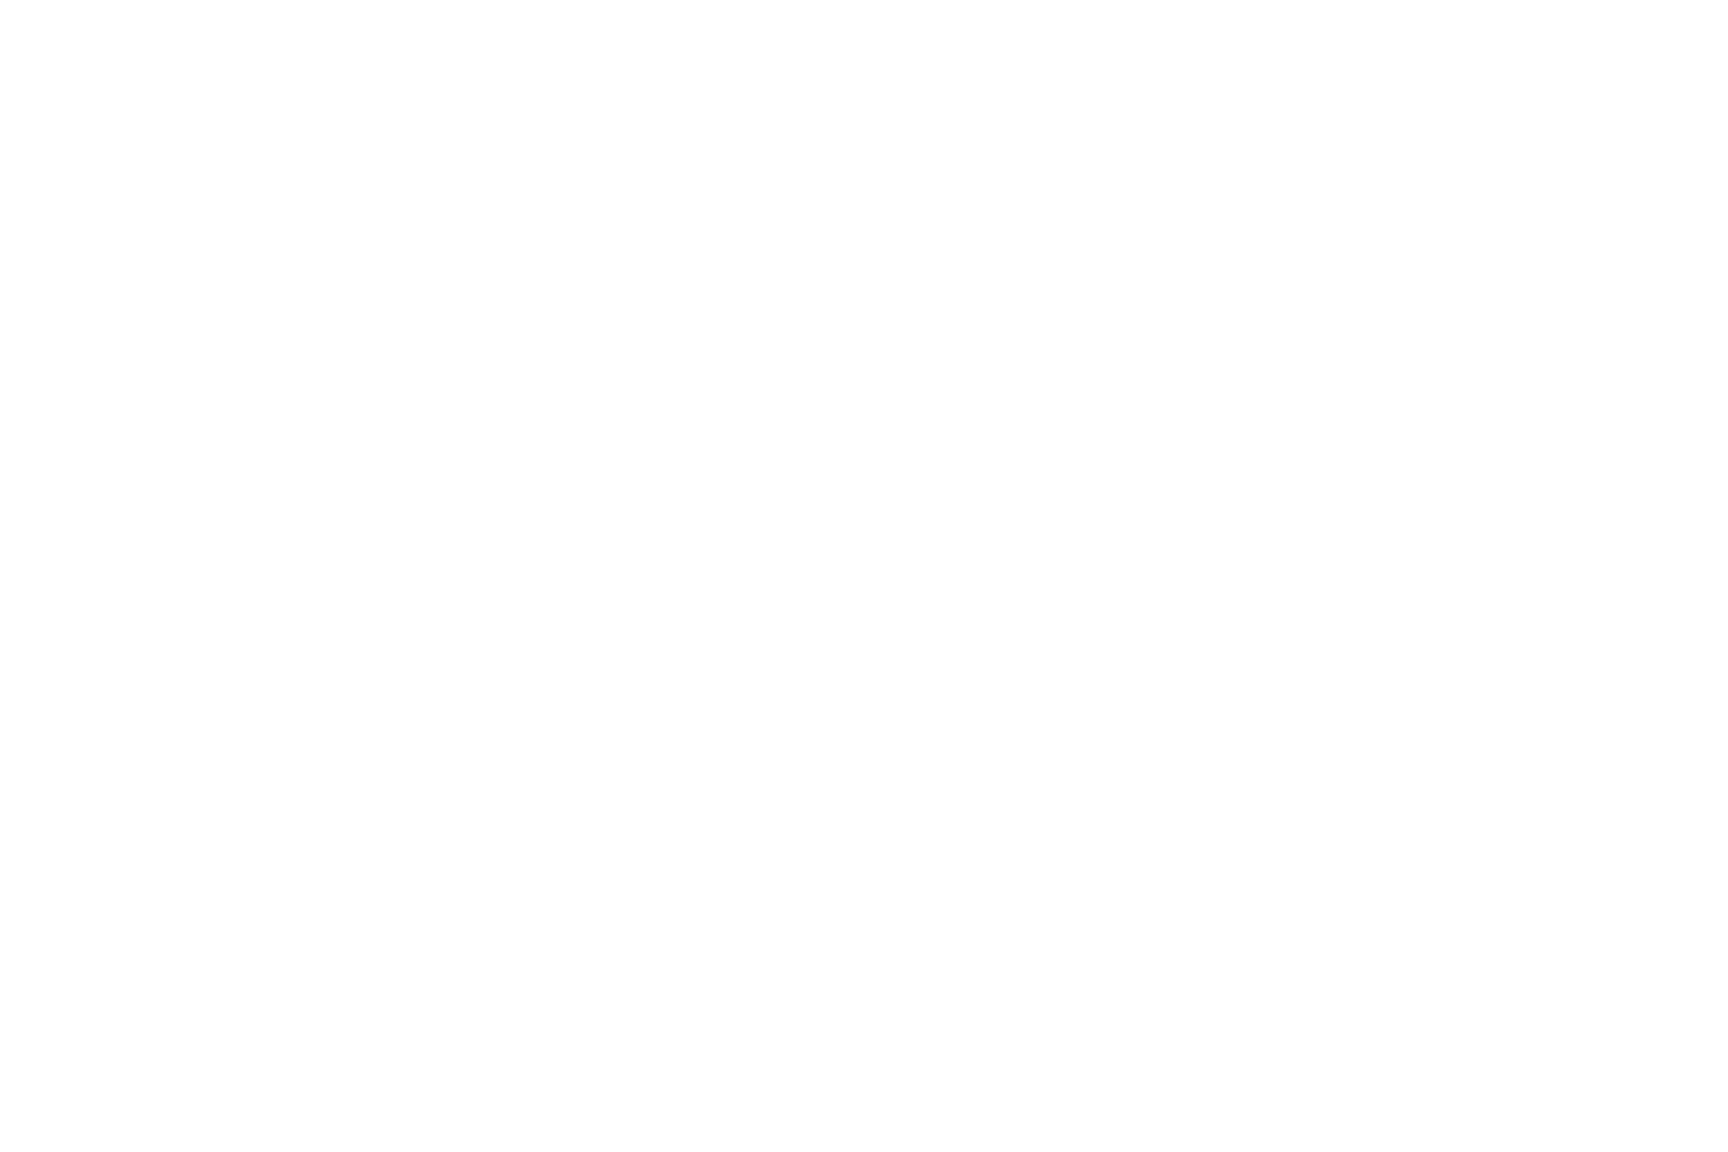


 67%|██████▋   | 6/9 [05:25<02:43, 54.34s/it]

{'batch_size': 100, 'epochs': 100, 'lr': 0.004, 'n_samples': 4700, 'n_units': 16, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


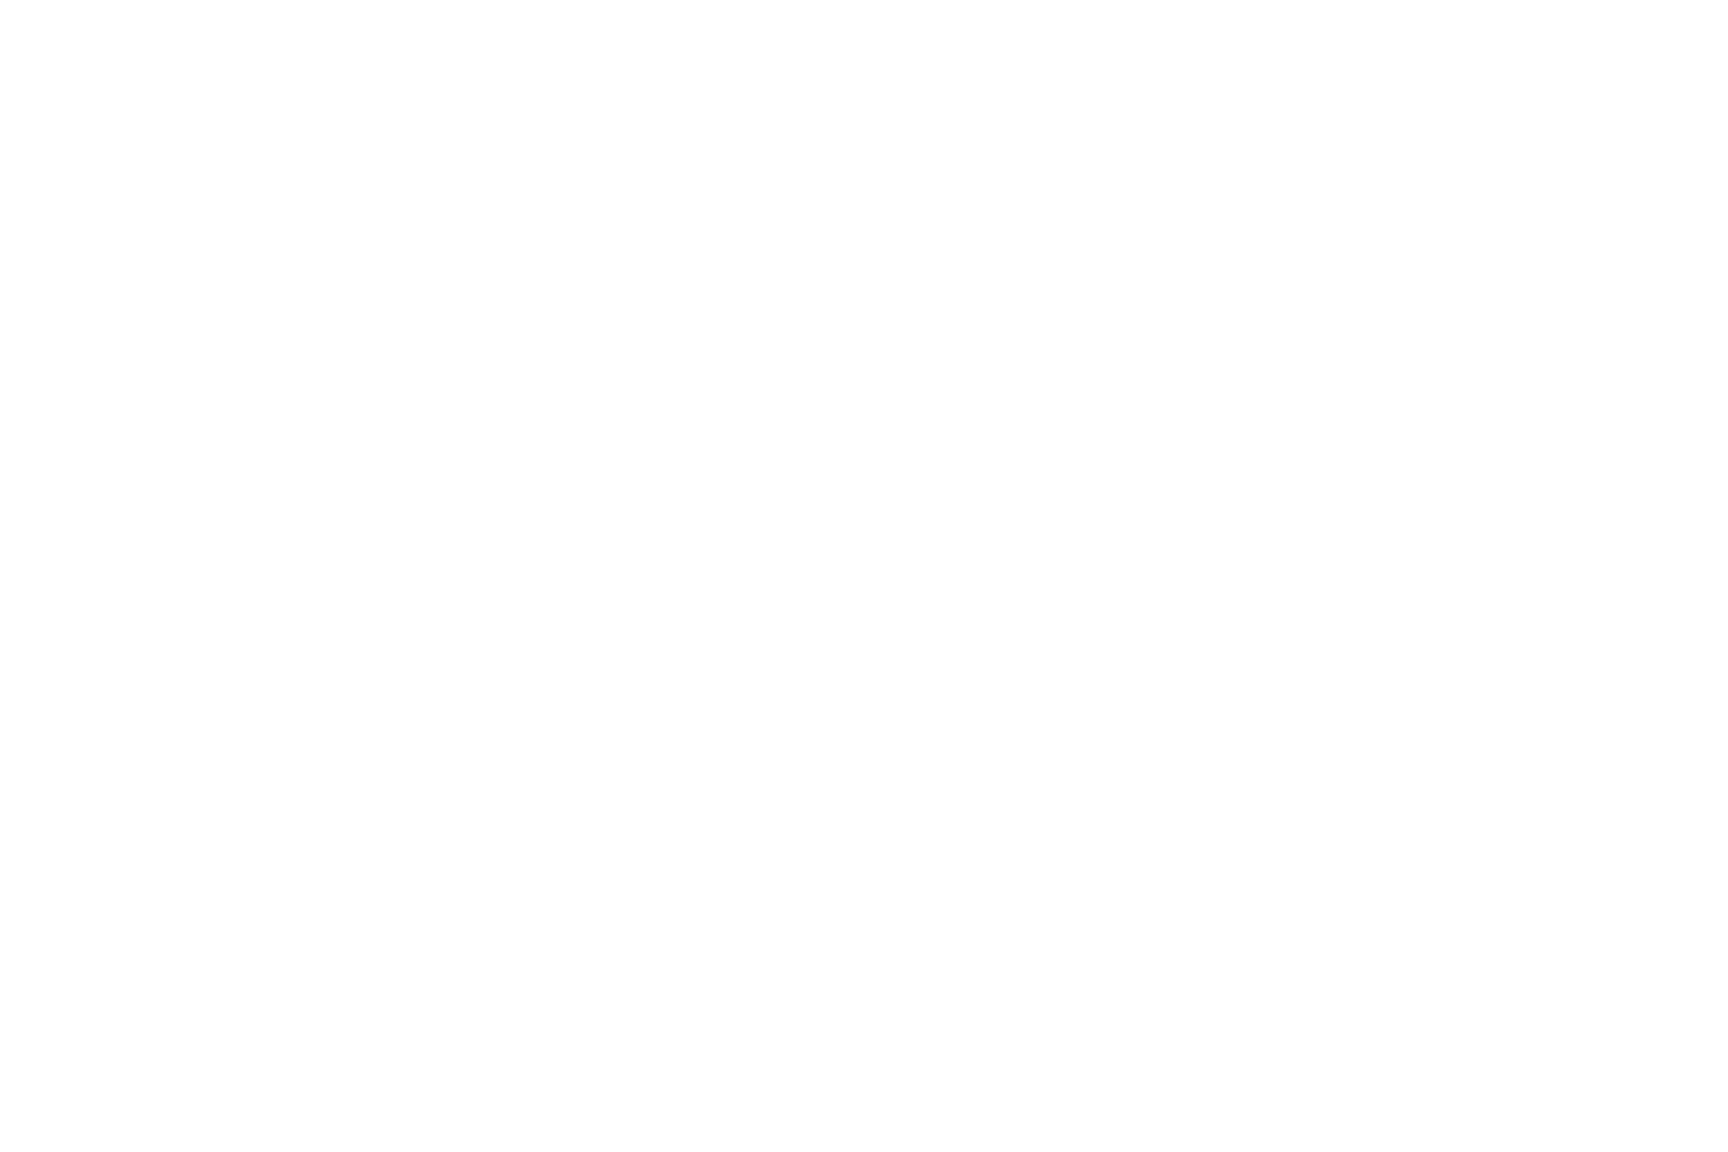


 78%|███████▊  | 7/9 [06:19<01:48, 54.06s/it]

{'batch_size': 100, 'epochs': 100, 'lr': 0.004, 'n_samples': 4700, 'n_units': 20, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


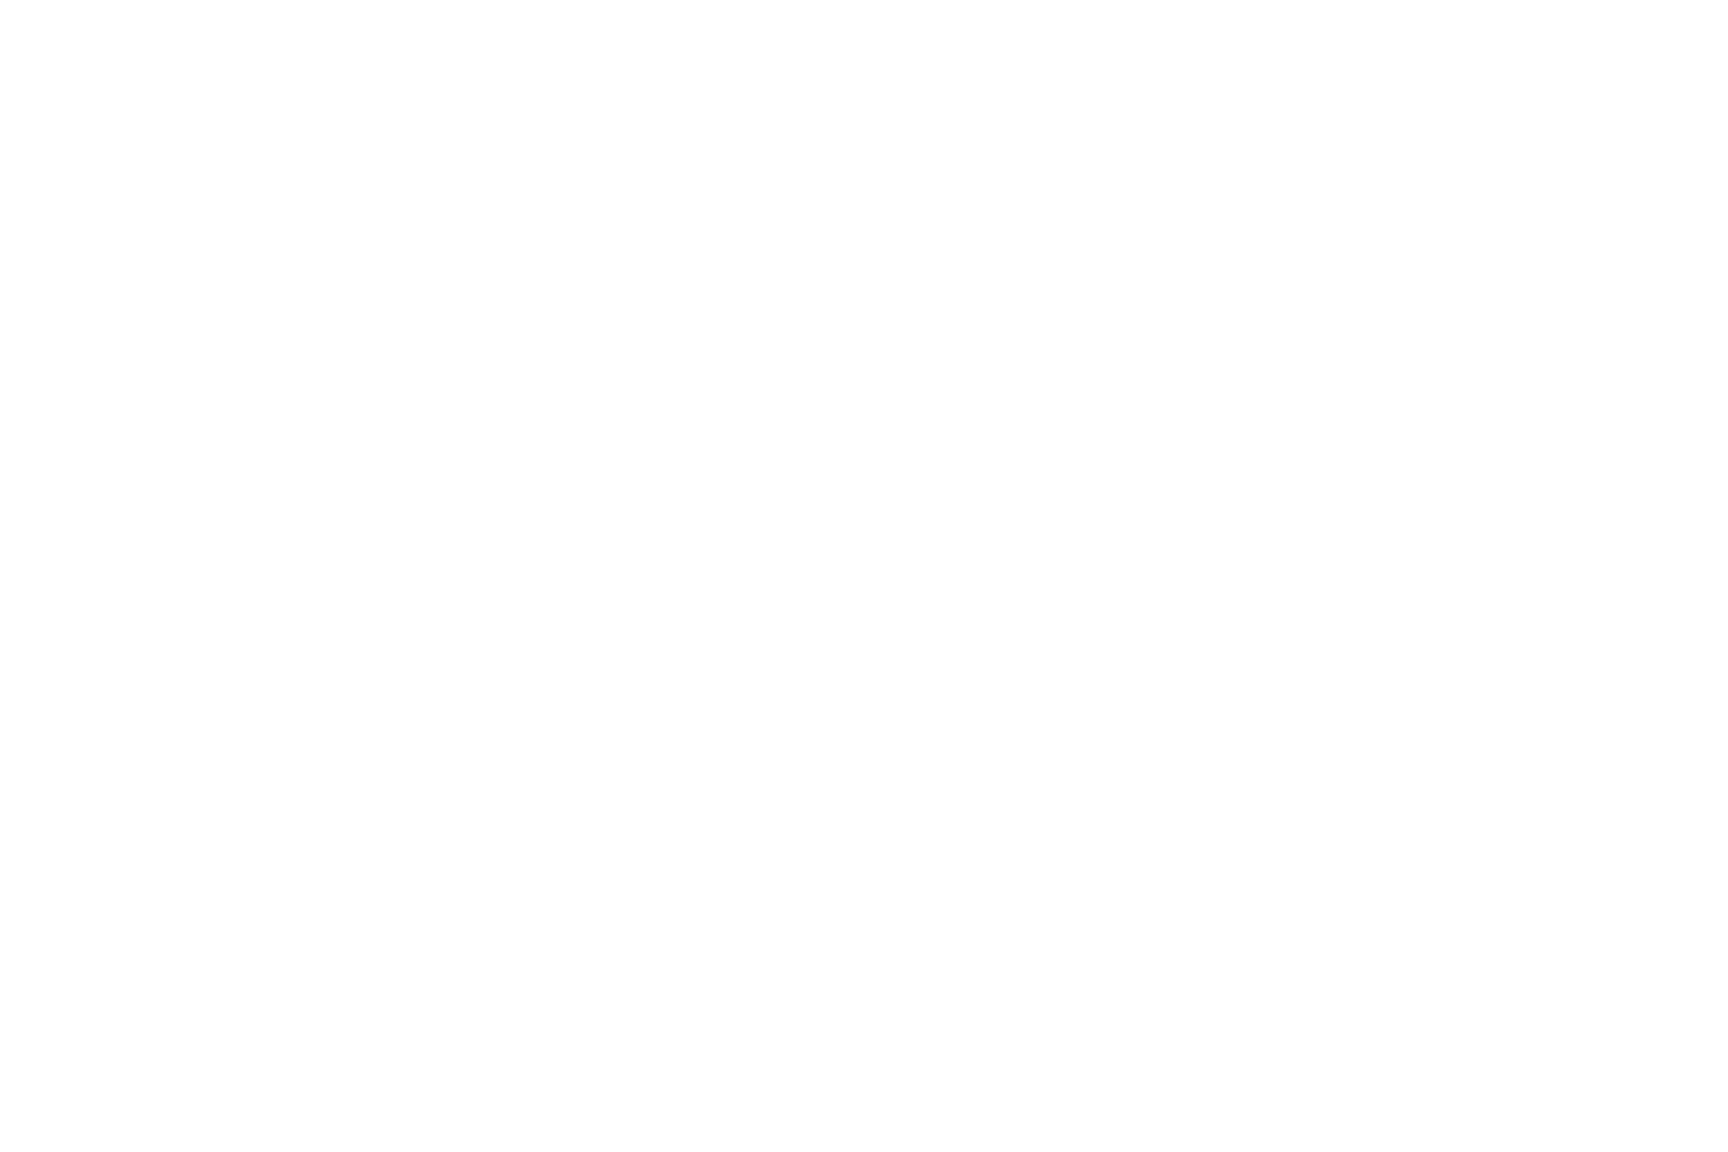


 89%|████████▉ | 8/9 [07:14<00:54, 54.25s/it]

{'batch_size': 100, 'epochs': 100, 'lr': 0.004, 'n_samples': 4700, 'n_units': 24, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


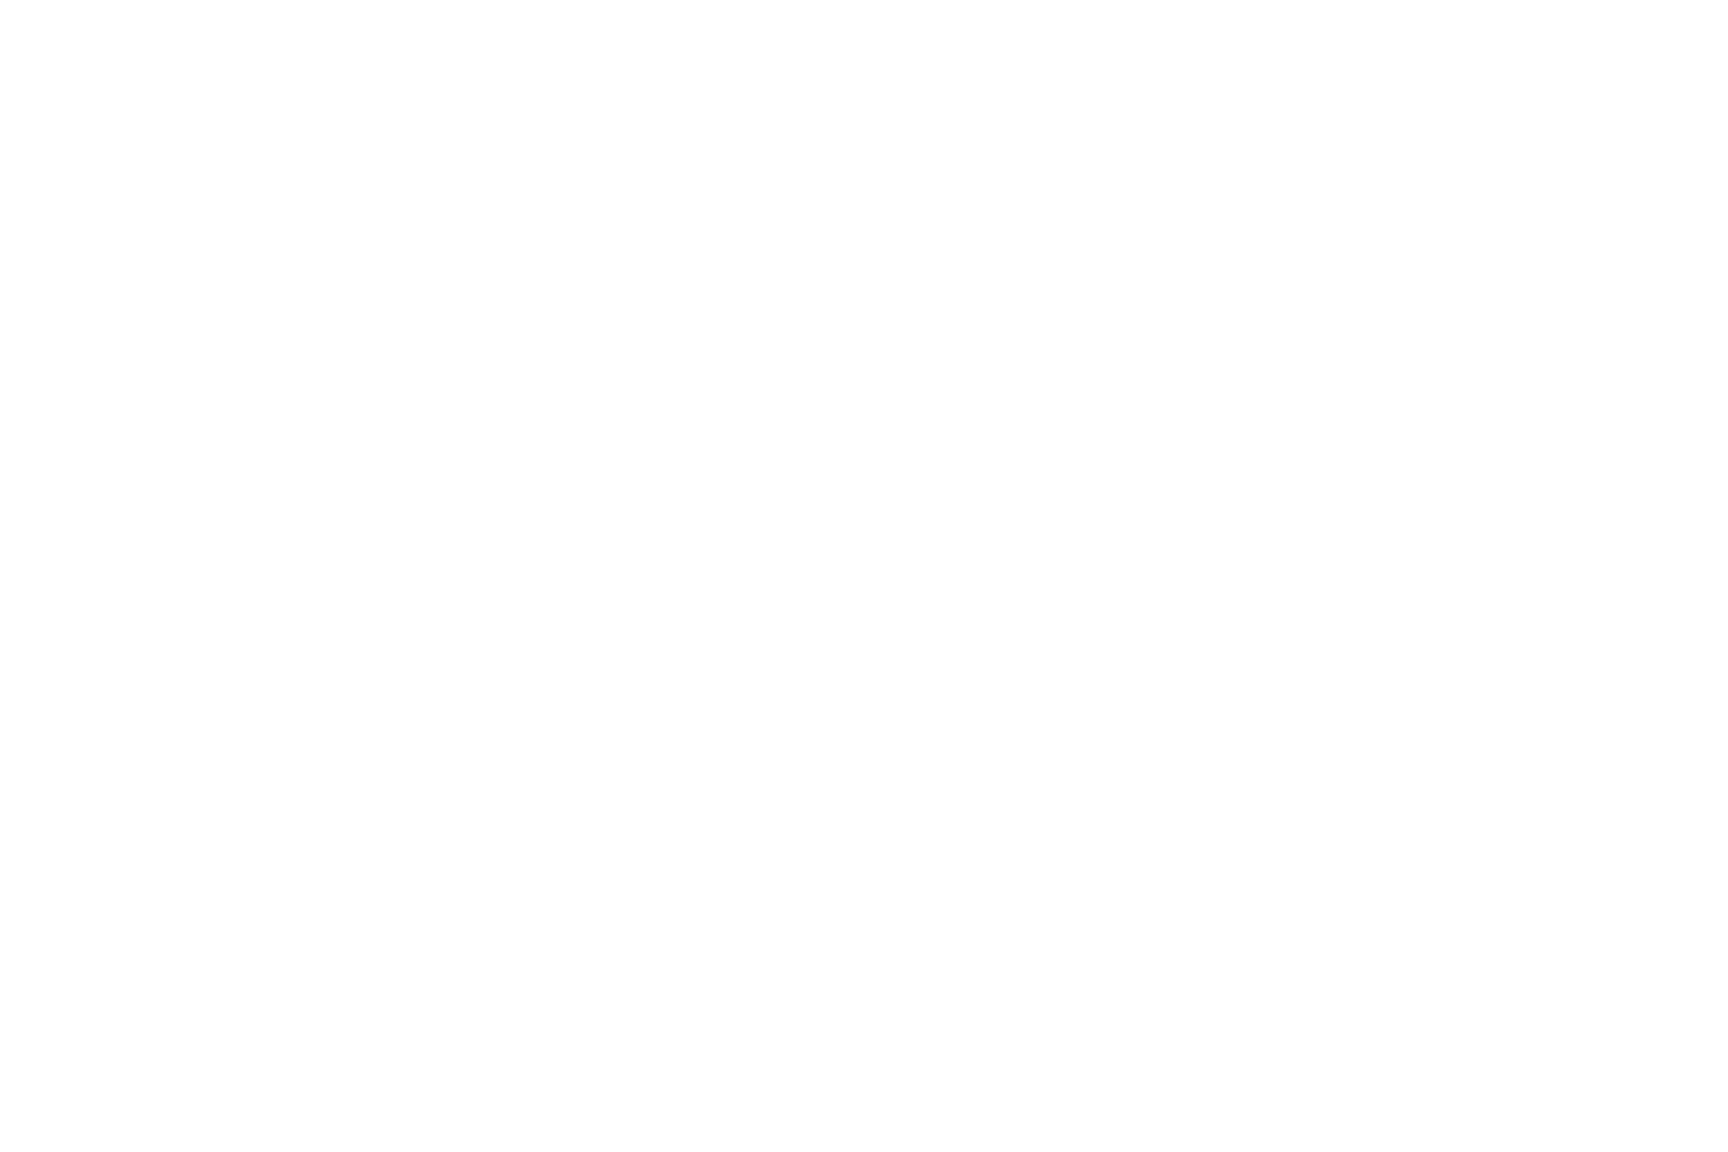


100%|██████████| 9/9 [08:08<00:00, 54.44s/it]

<IPython.core.display.Javascript object>


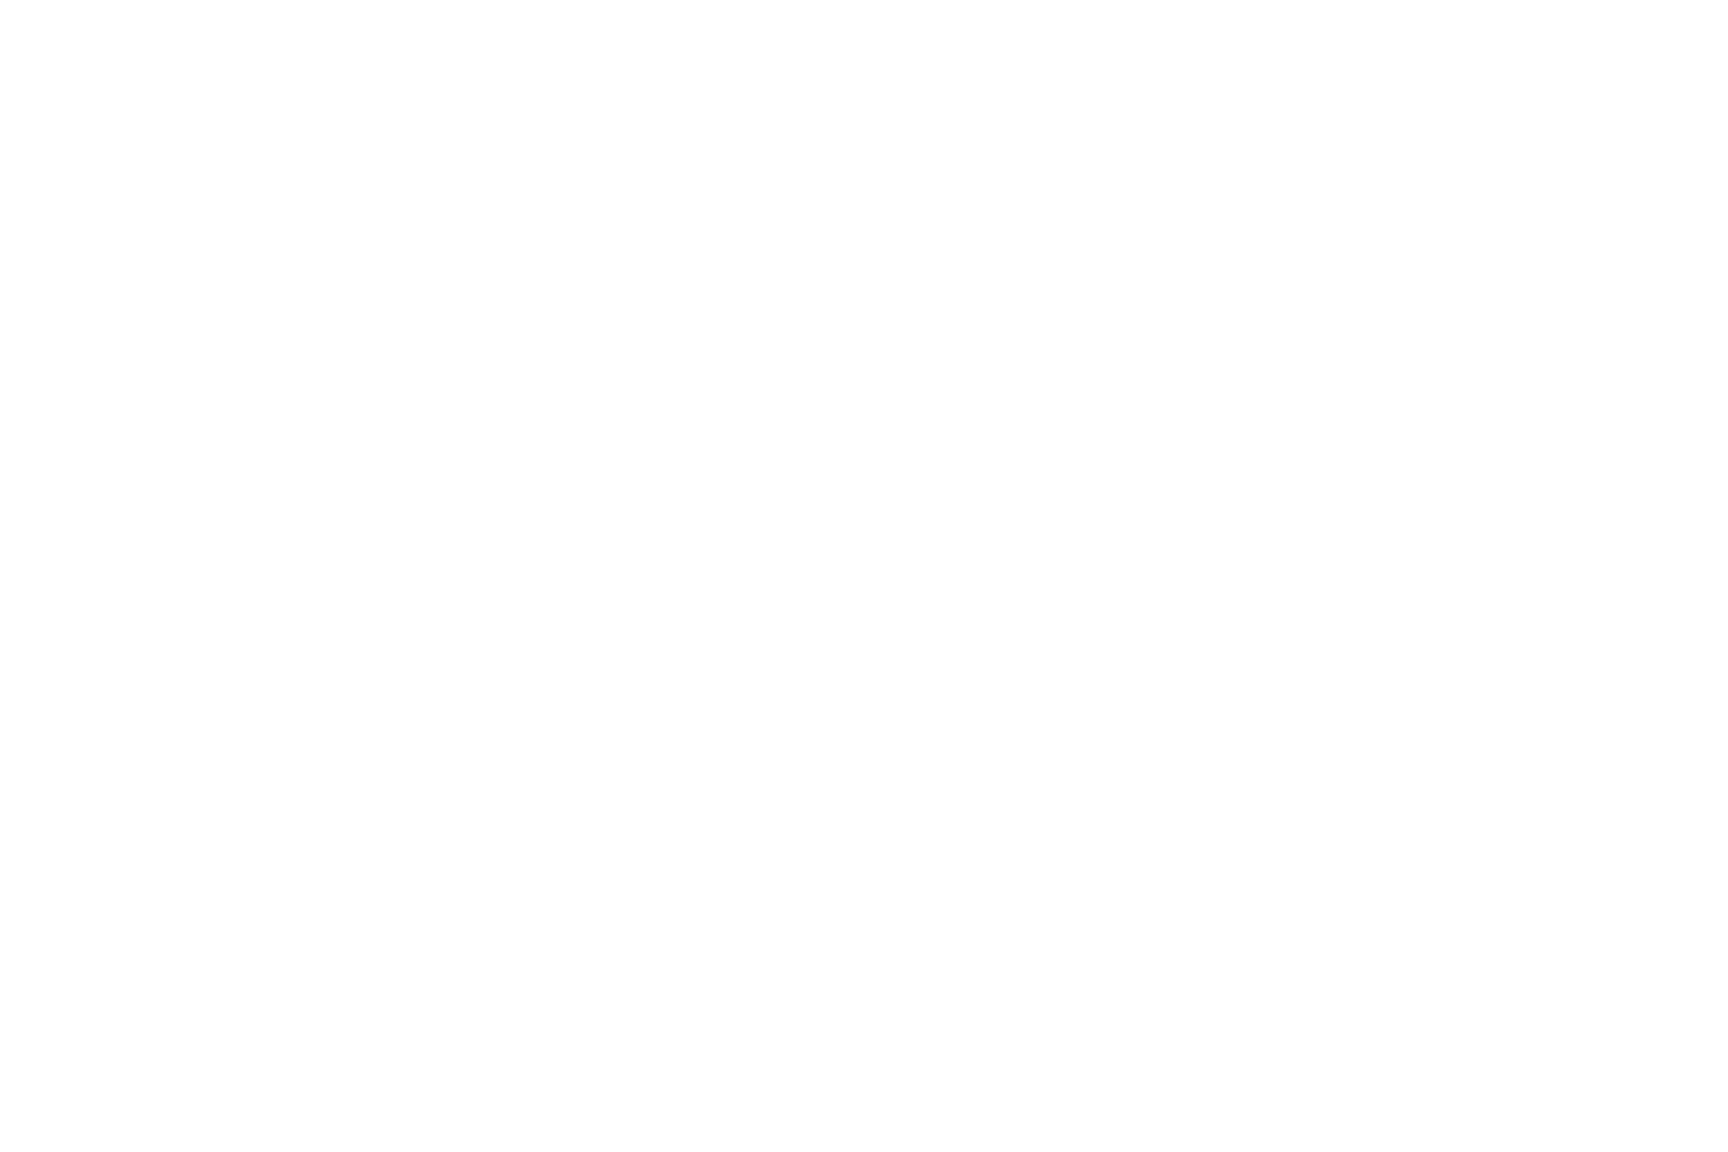

<IPython.core.display.Javascript object>


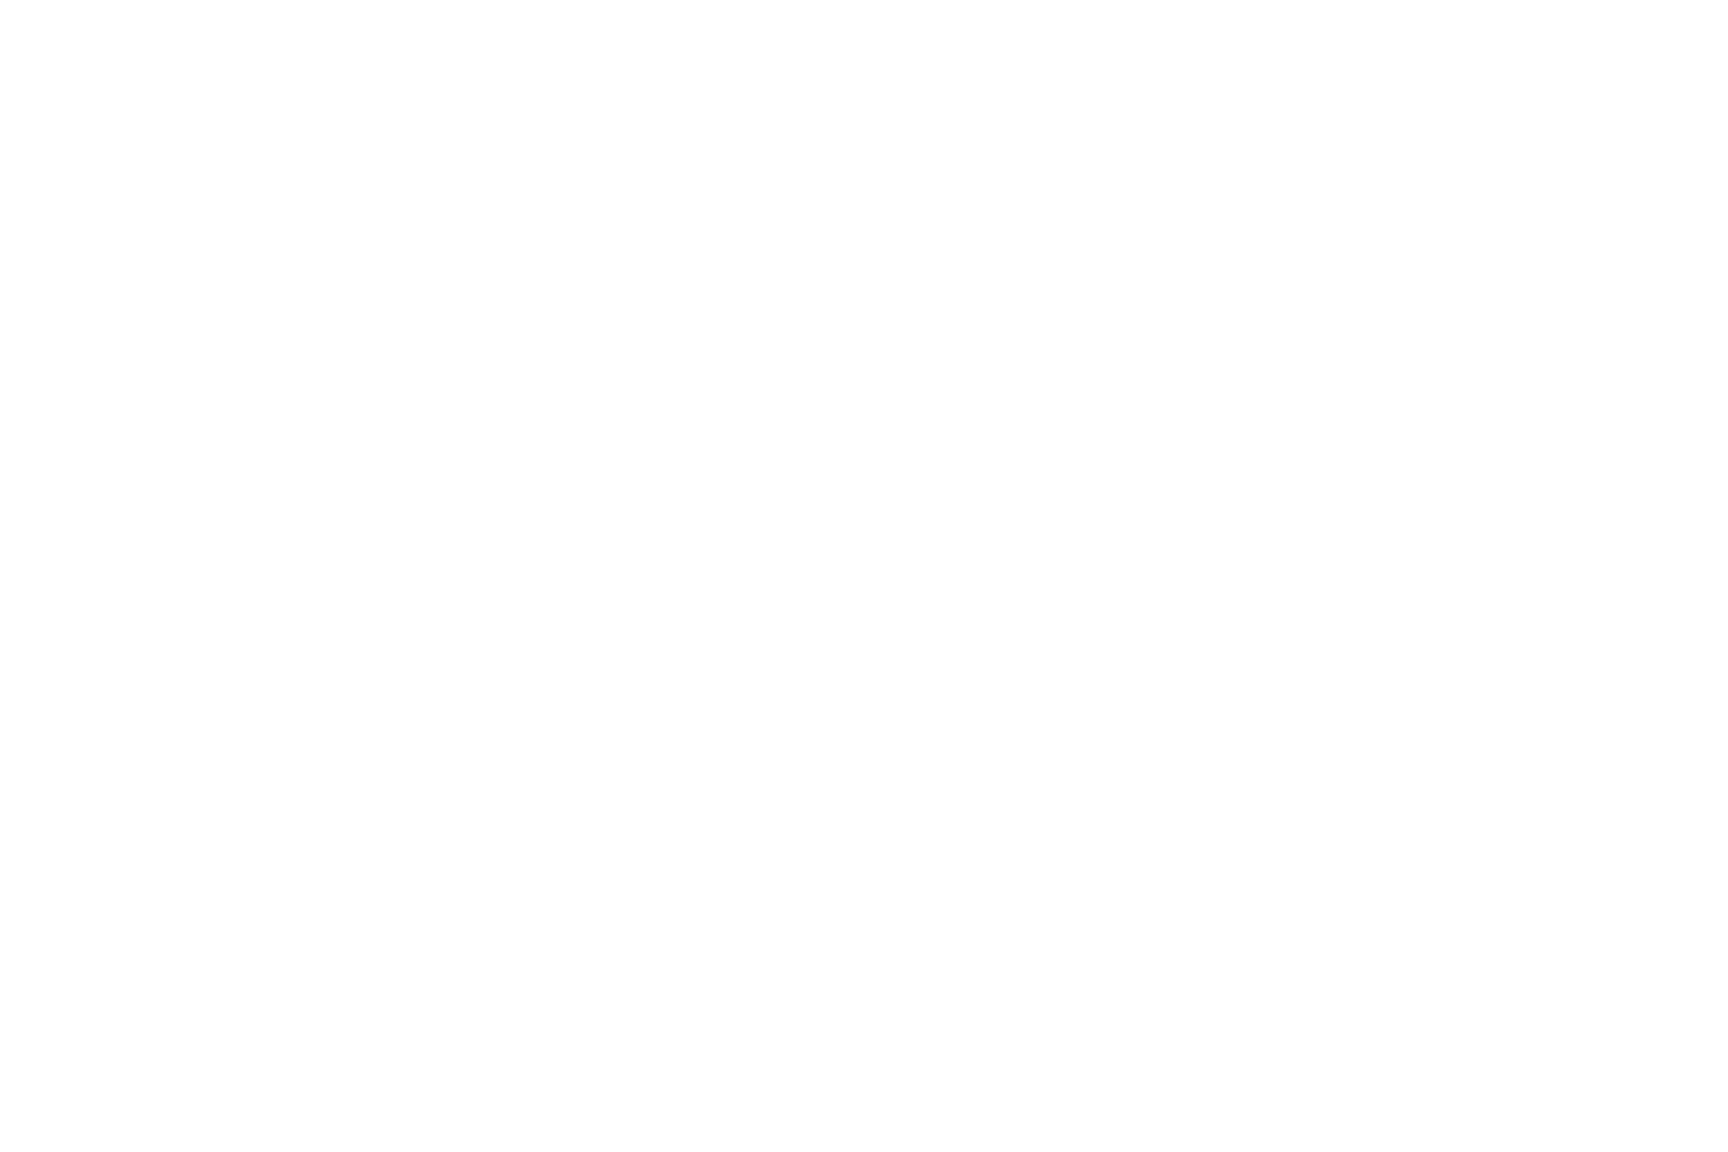

<IPython.core.display.Javascript object>


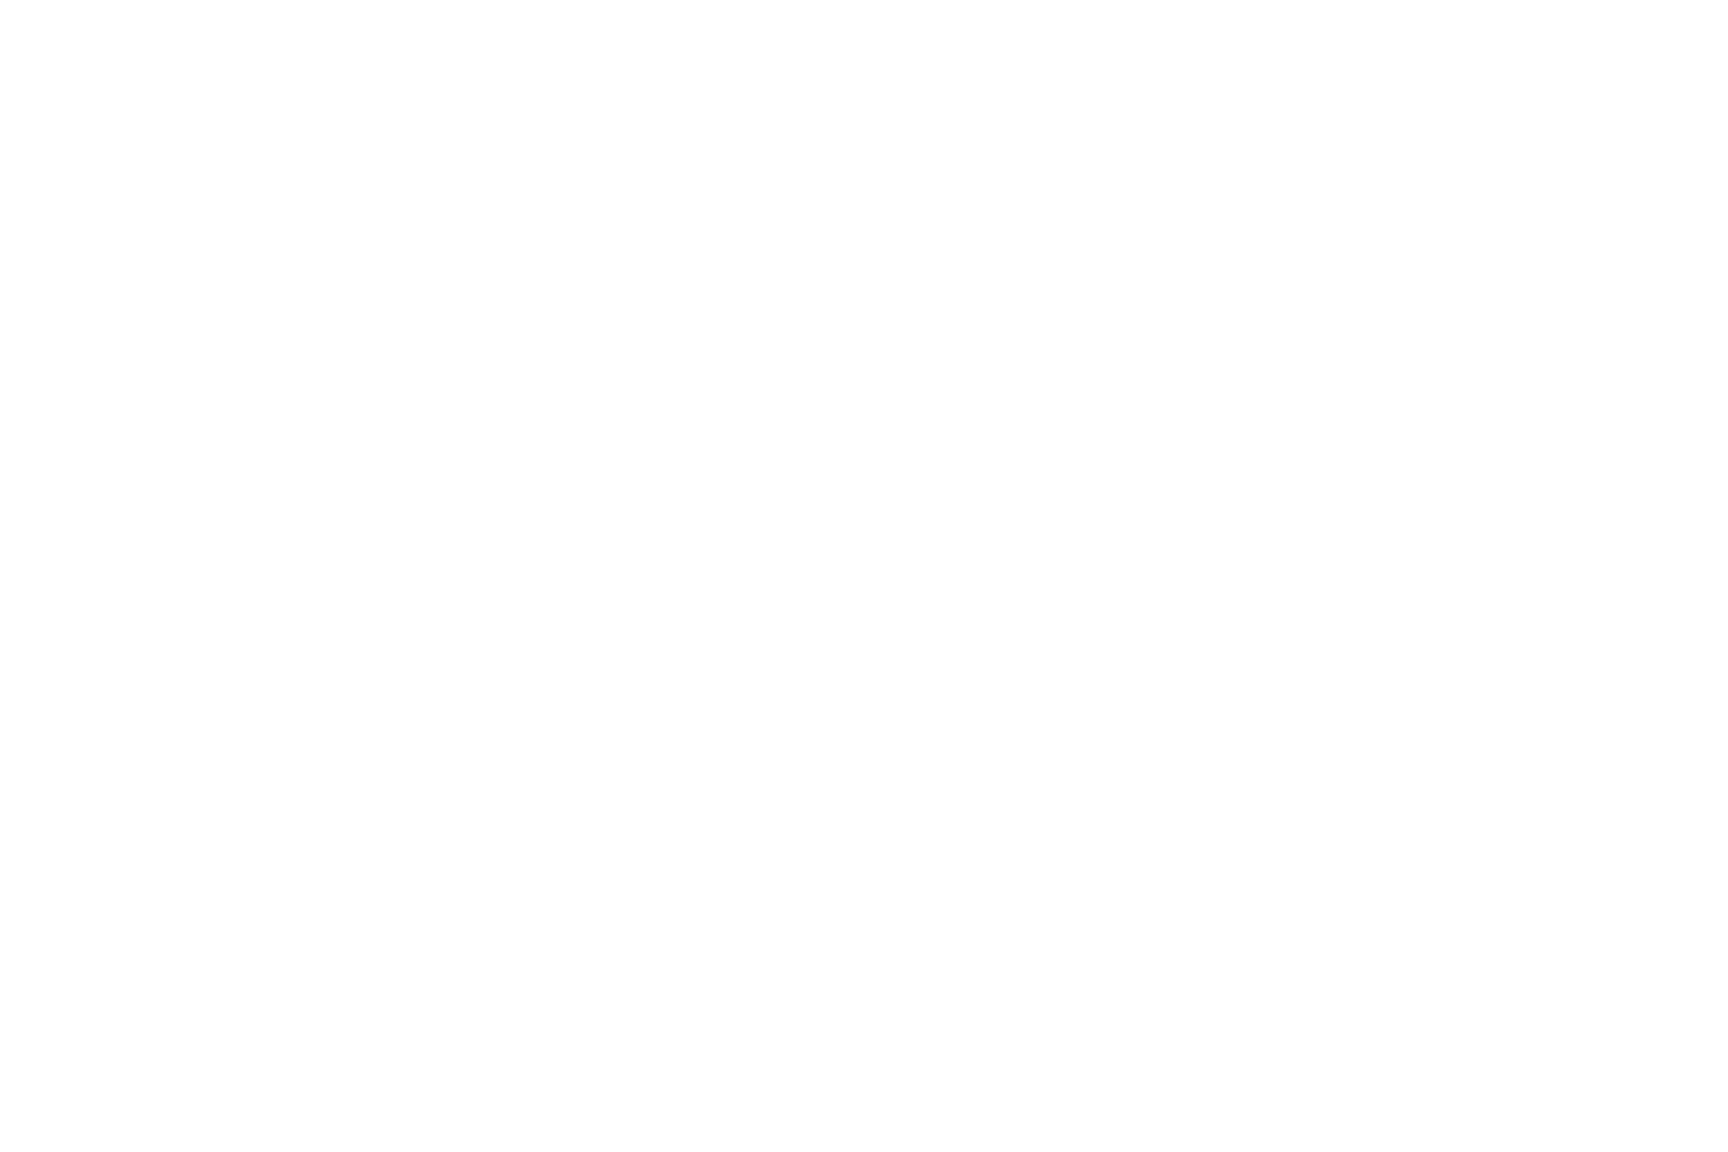

<IPython.core.display.Javascript object>


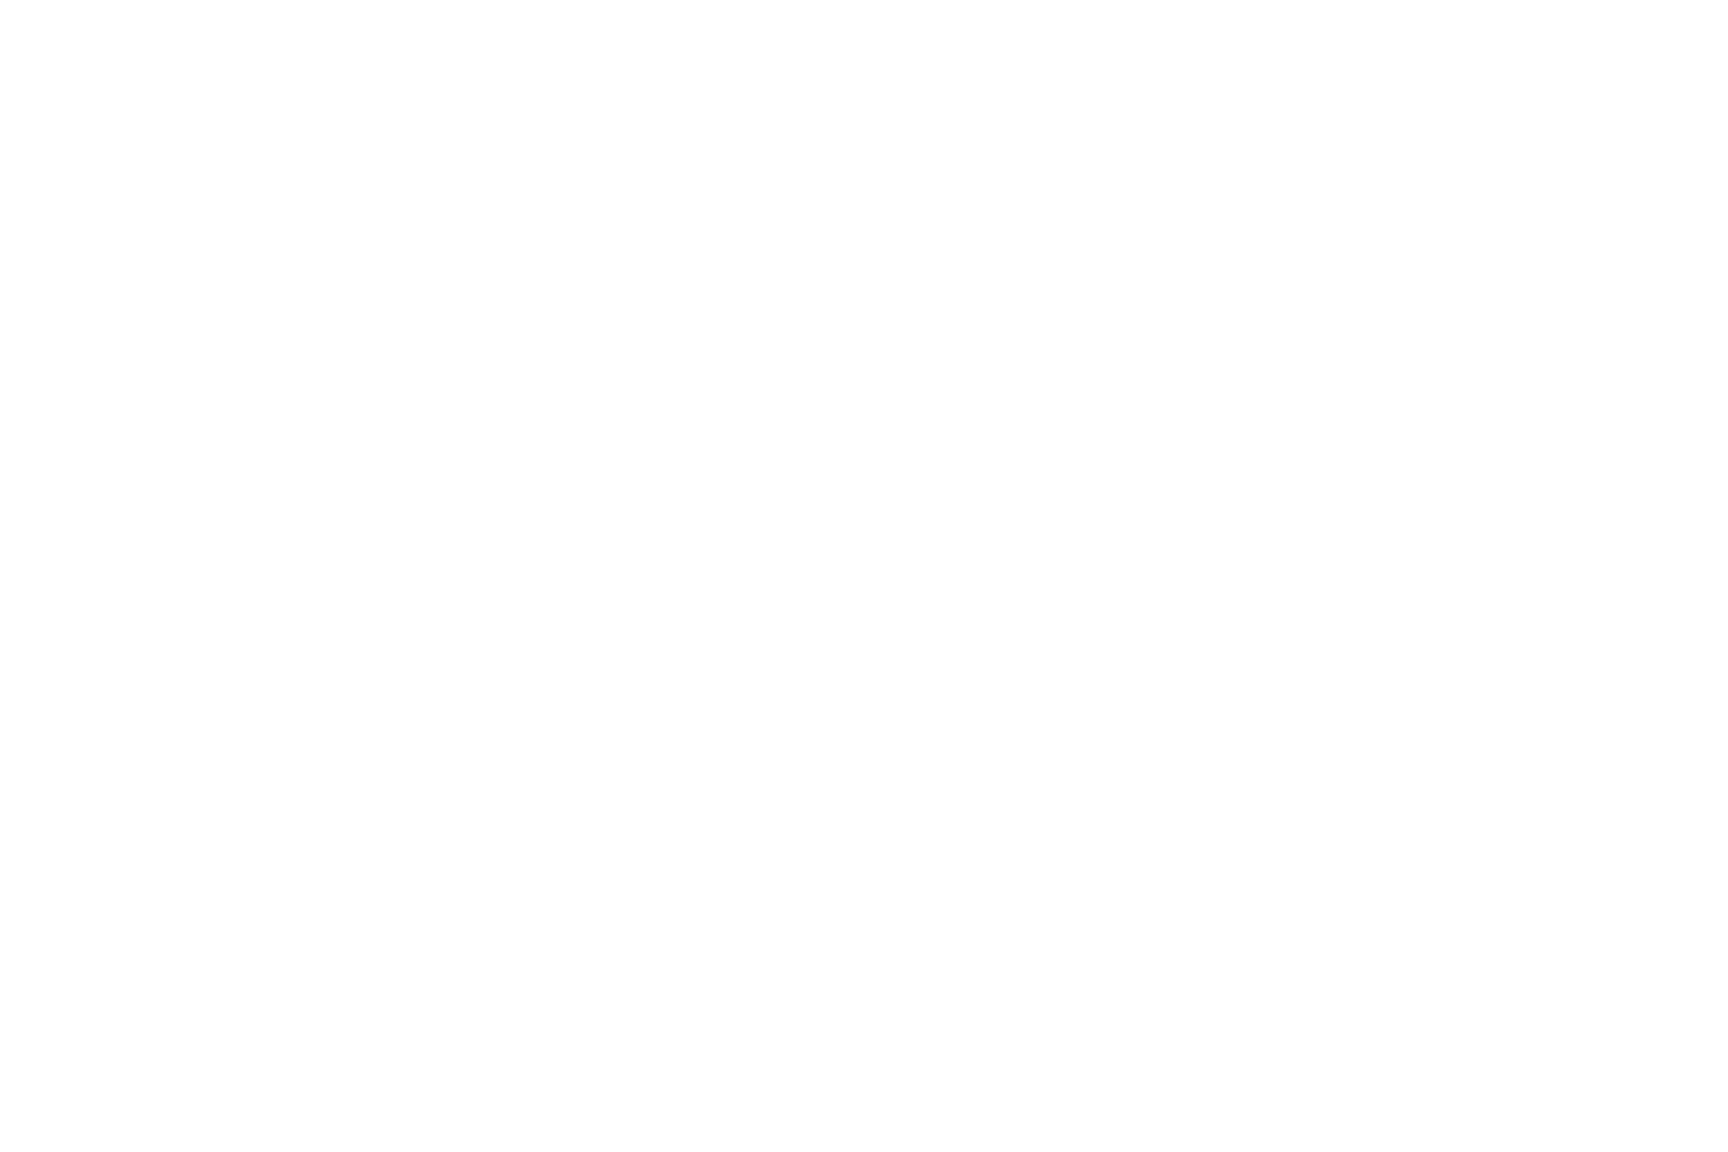

<IPython.core.display.Javascript object>


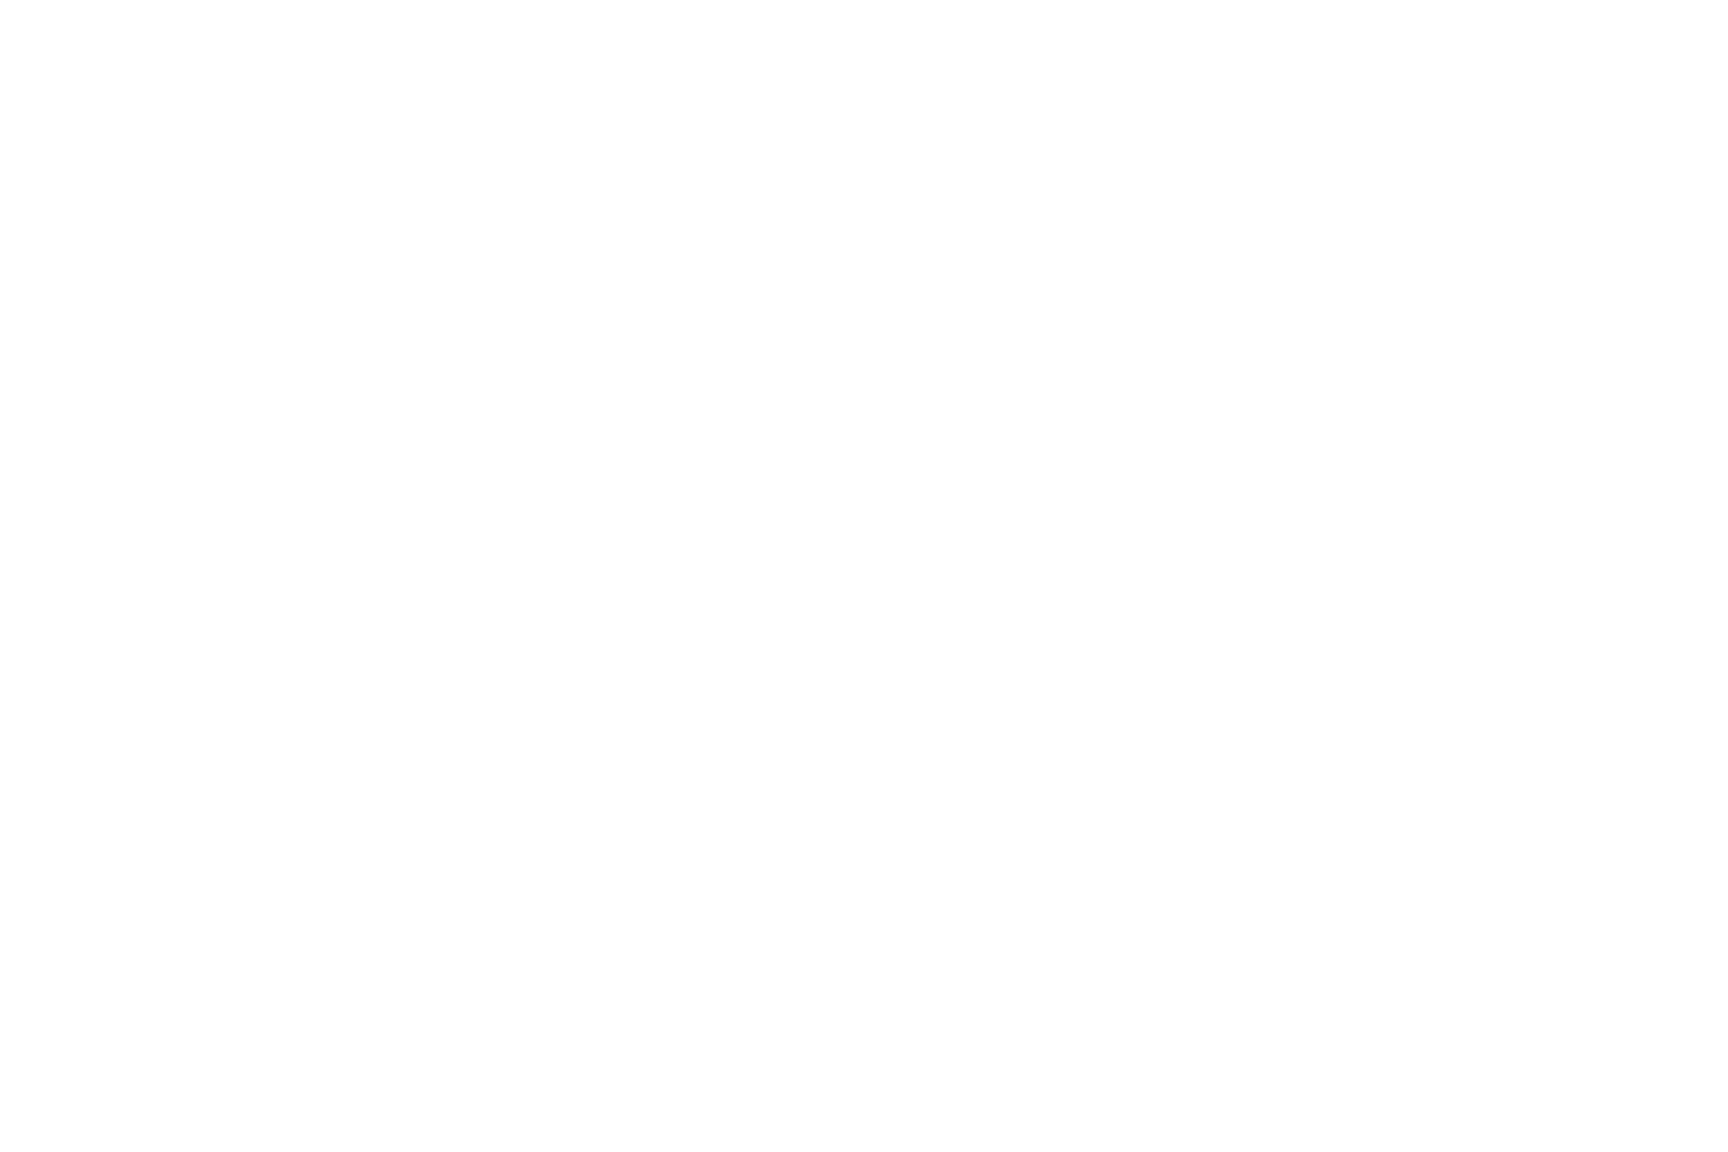

<IPython.core.display.Javascript object>


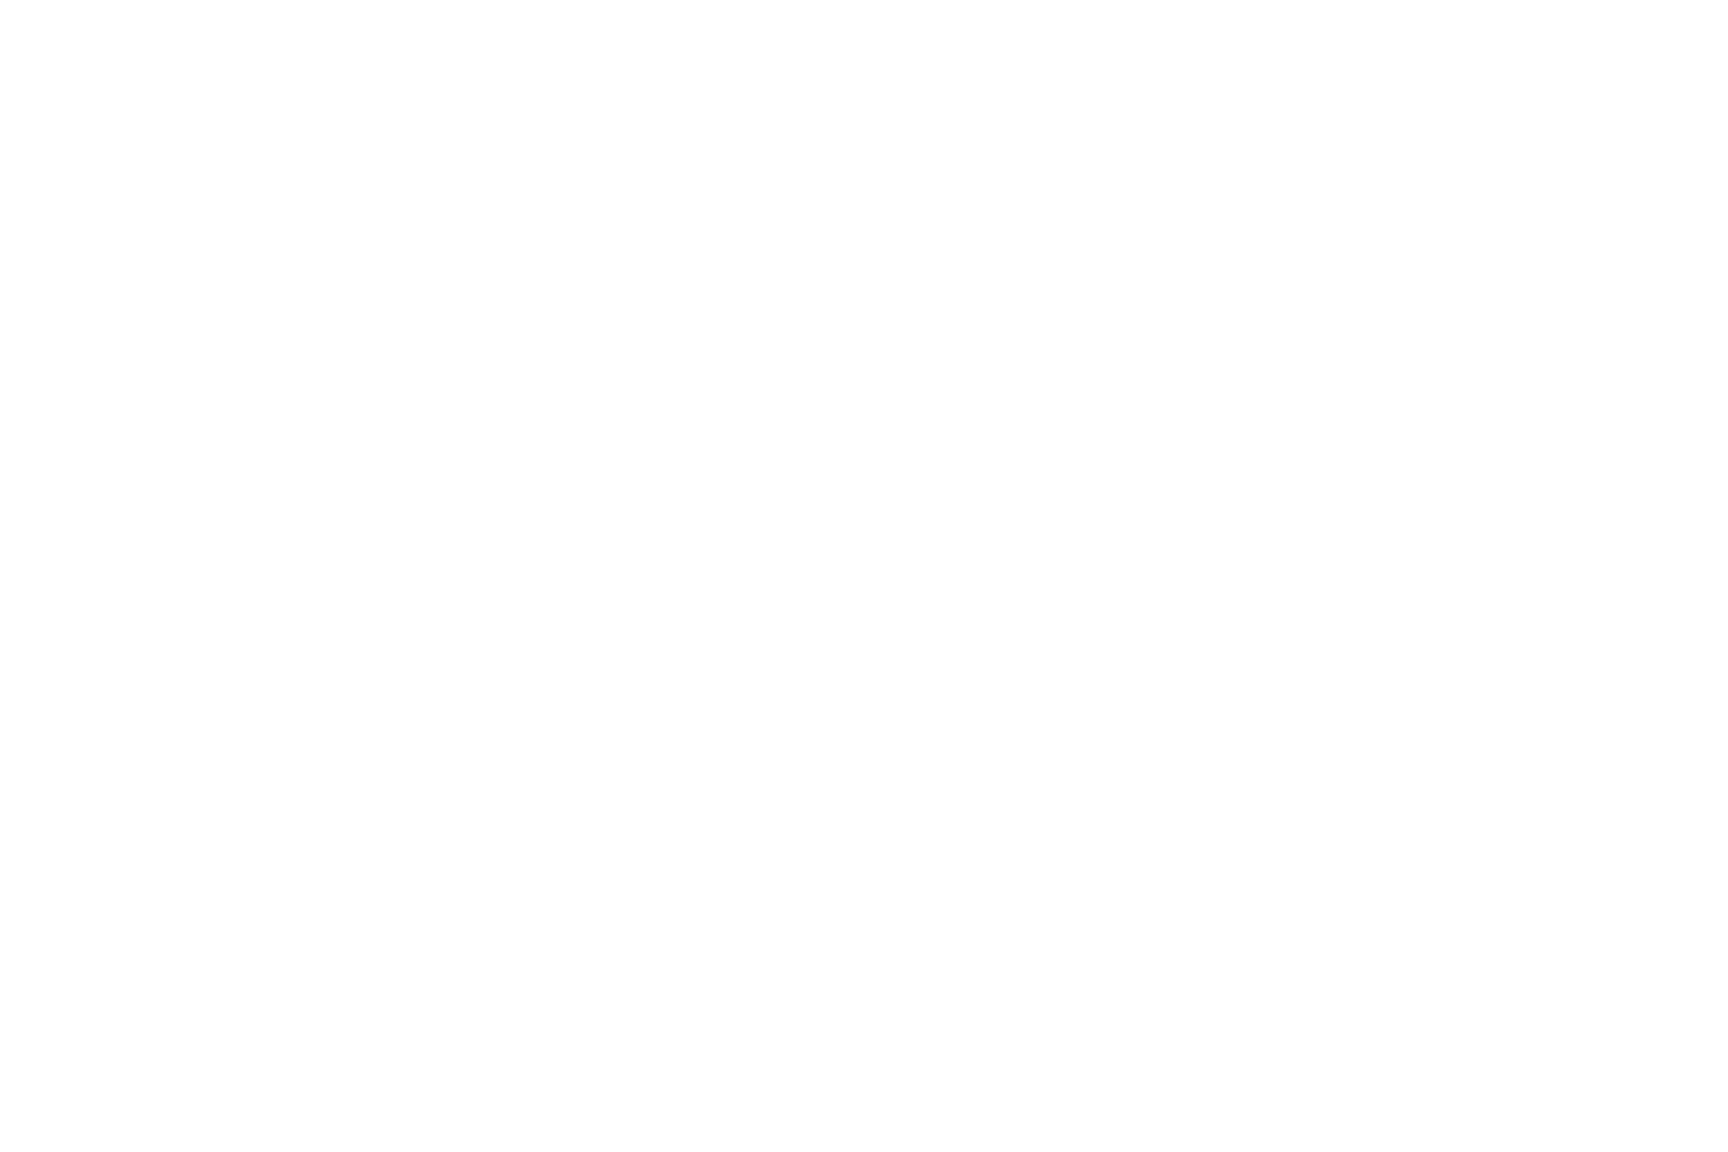

<IPython.core.display.Javascript object>


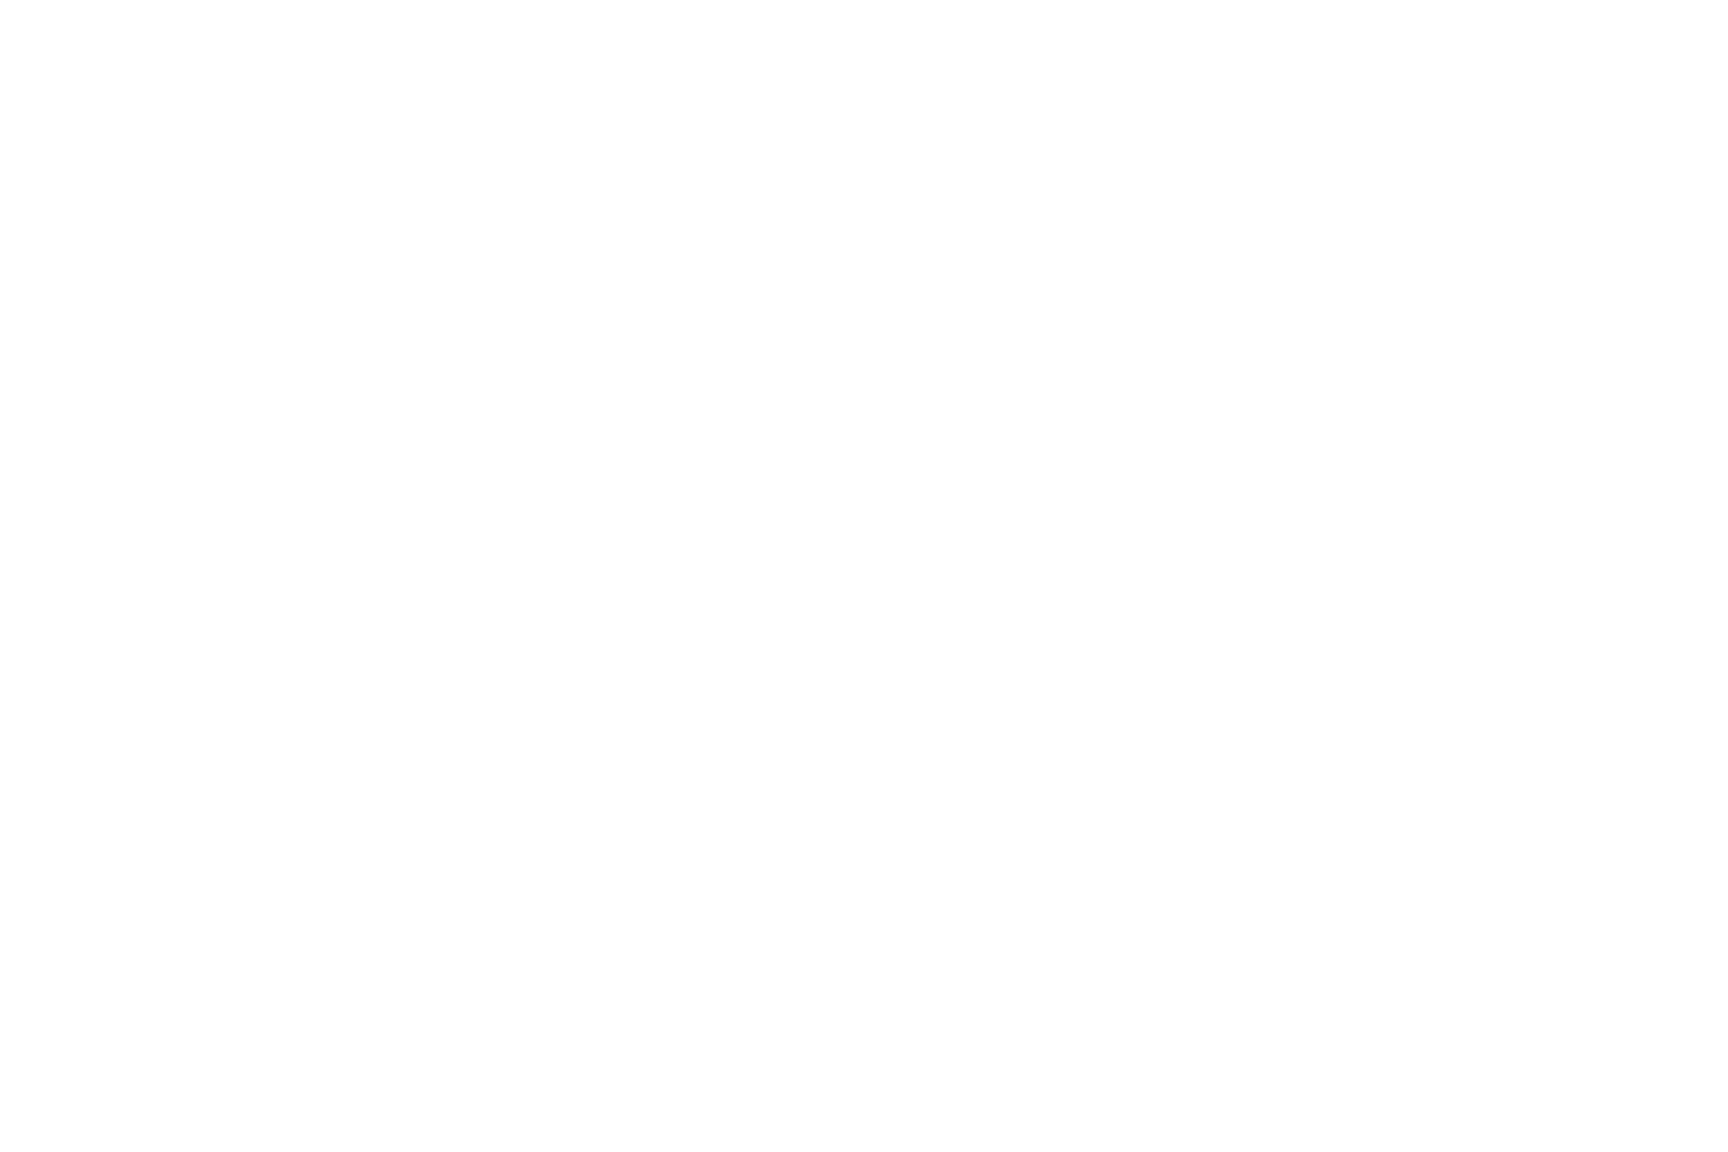

<IPython.core.display.Javascript object>


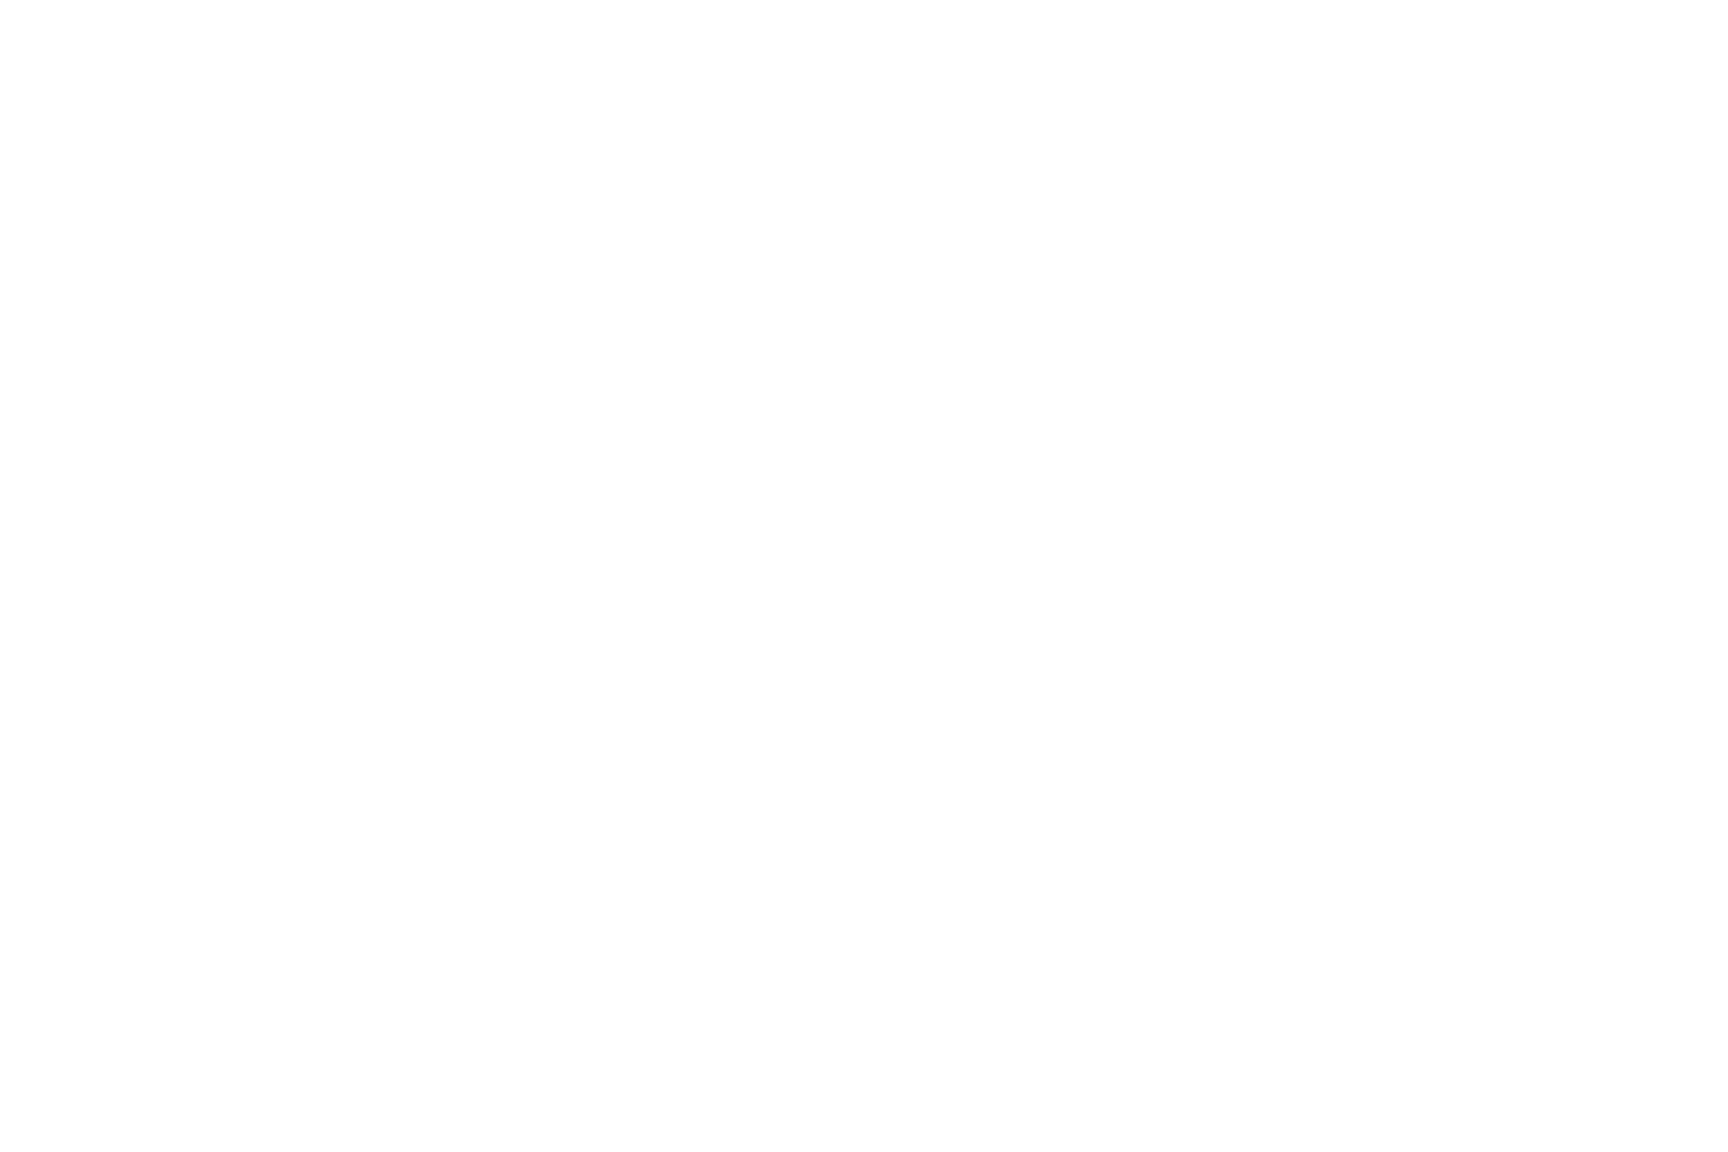

<IPython.core.display.Javascript object>


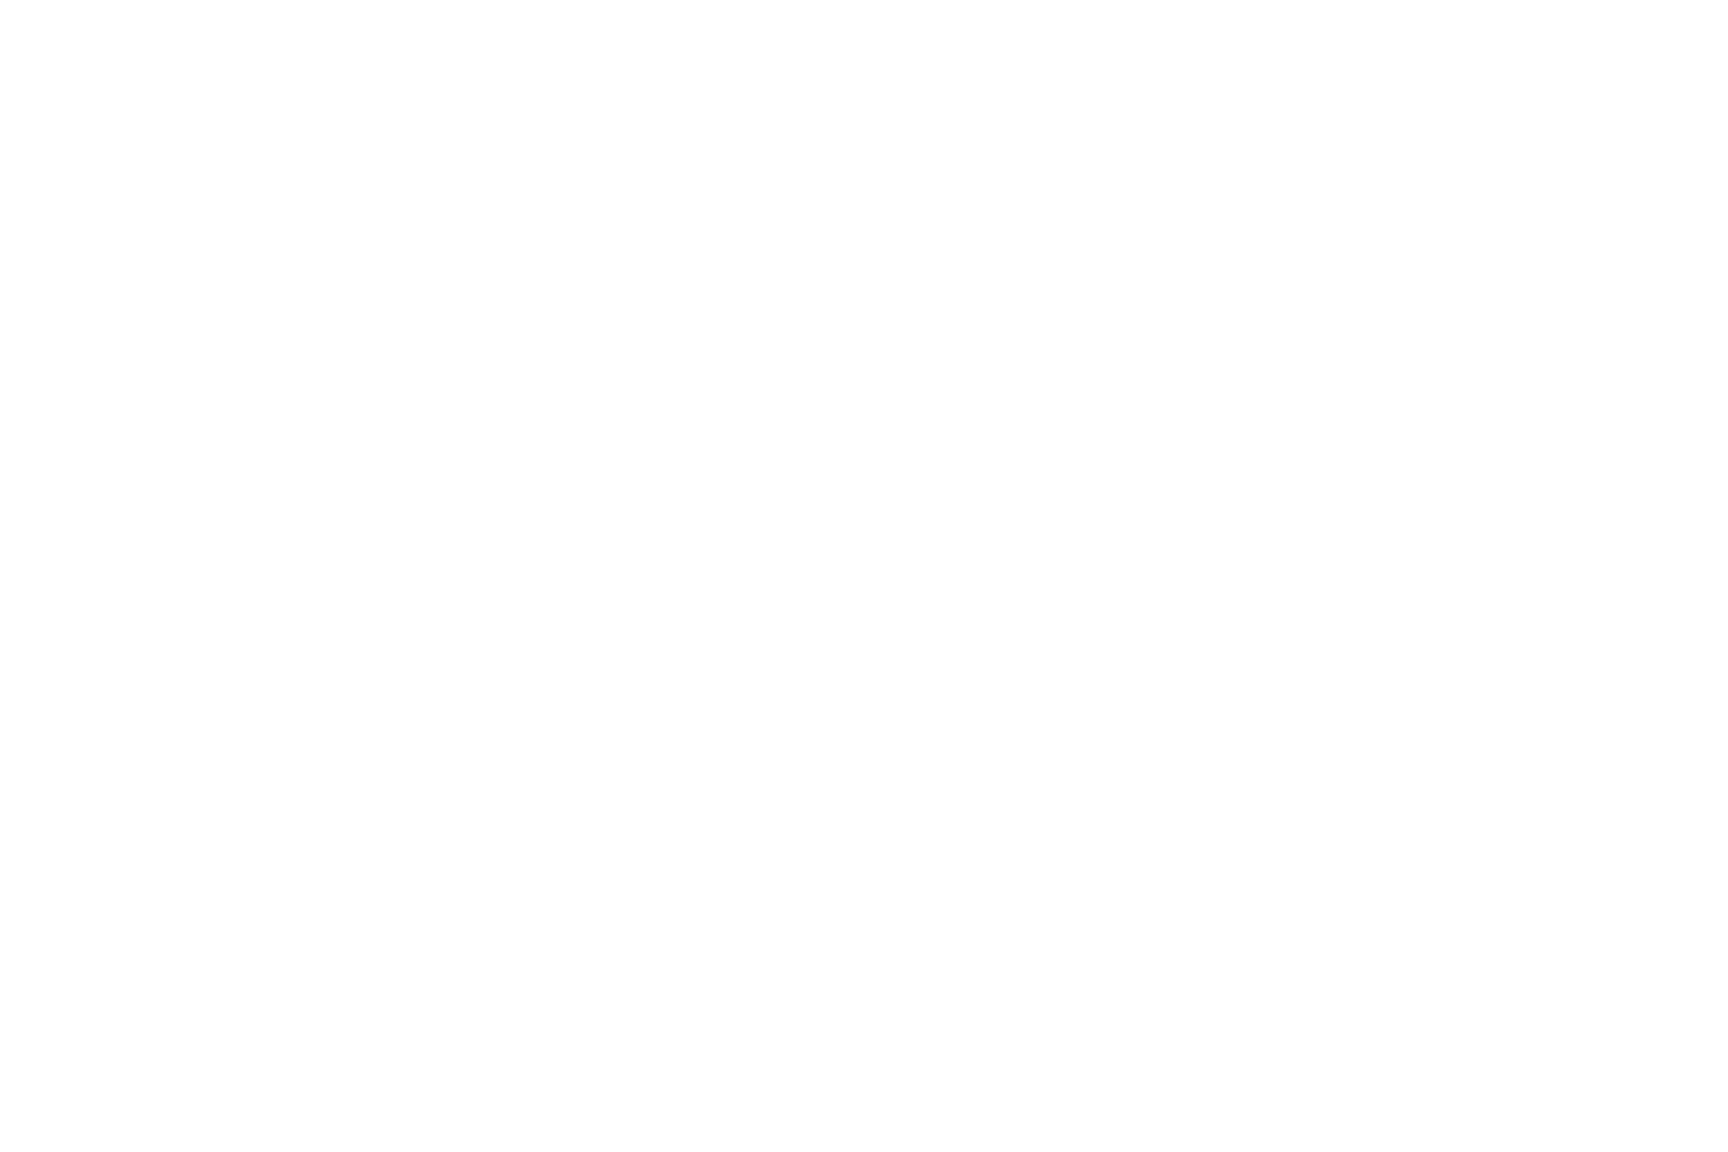

In [113]:
%matplotlib notebook

from keras.optimizers import Adam, Nadam, RMSprop
import talos as ta

p = {
     'lr': [0.001, 0.002, 0.004],
     'n_samples': [4700],
     'n_units': [16, 20, 24],
#      'batch_size': [10, 100, 1000],
     'batch_size': [100],
     'epochs': [100],
     # 'dropout': (0, 0.5, 5),
     # 'weight_regulizer':[None],
     # 'emb_output_dims': [None],
     # 'shape':['brick','long_funnel'],
     'optimizer': [Adam],
 }

# 'lr': 0.004,
# 'n_samples': 44000 * 3,
# 'n_units': 20,
# 'batch_size': 500,
# 'epochs': 100,
# 'optimizer': keras.optimizers.Adam,
        
# and run the experiment
t = ta.Scan(x=X_tr_s[:np.max(p['n_samples'])],
            y=y_tr_s[:np.max(p['n_samples'])],
            model=create_and_train_model,
#             grid_downsample=0.5,
            params=p)

globals().update(locals())

In [114]:
r = ta.Reporting(t)
r.data.sort_values(by='loss')


,round_epochs,loss,lr,batch_size,epochs,lr,n_samples,n_units,optimizer
7,100,0.064101,0.00256,100,100,0.004,4700,20,<class 'keras.optimizers.Adam'>
8,100,0.073632,0.00256,100,100,0.004,4700,24,<class 'keras.optimizers.Adam'>
6,100,0.085991,0.00256,100,100,0.004,4700,16,<class 'keras.optimizers.Adam'>
3,100,0.088374,0.00128,100,100,0.002,4700,16,<class 'keras.optimizers.Adam'>
5,100,0.096870,0.00128,100,100,0.002,4700,24,<class 'keras.optimizers.Adam'>
4,100,0.106031,0.00128,100,100,0.002,4700,20,<class 'keras.optimizers.Adam'>
0,100,0.117395,0.00064,100,100,0.001,4700,16,<class 'keras.optimizers.Adam'>
2,100,0.124886,0.00064,100,100,0.001,4700,24,<class 'keras.optimizers.Adam'>
1,100,0.126163,0.00064,100,100,0.001,4700,20,<class 'keras.optimizers.Adam'>


In [115]:
best_params = r.data.loc[7]
best_params

round_epochs                                100
loss                                  0.0641015
lr                                      0.00256
batch_size                                  100
epochs                                      100
lr                                        0.004
n_samples                                  4700
n_units                                      20
optimizer       <class 'keras.optimizers.Adam'>
Name: 7, dtype: object

In [116]:
type(best_params)

pandas.core.series.Series

{'lr': 0.003, 'n_samples': 4700, 'n_units': 20, 'batch_size': 100, 'epochs': 300, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


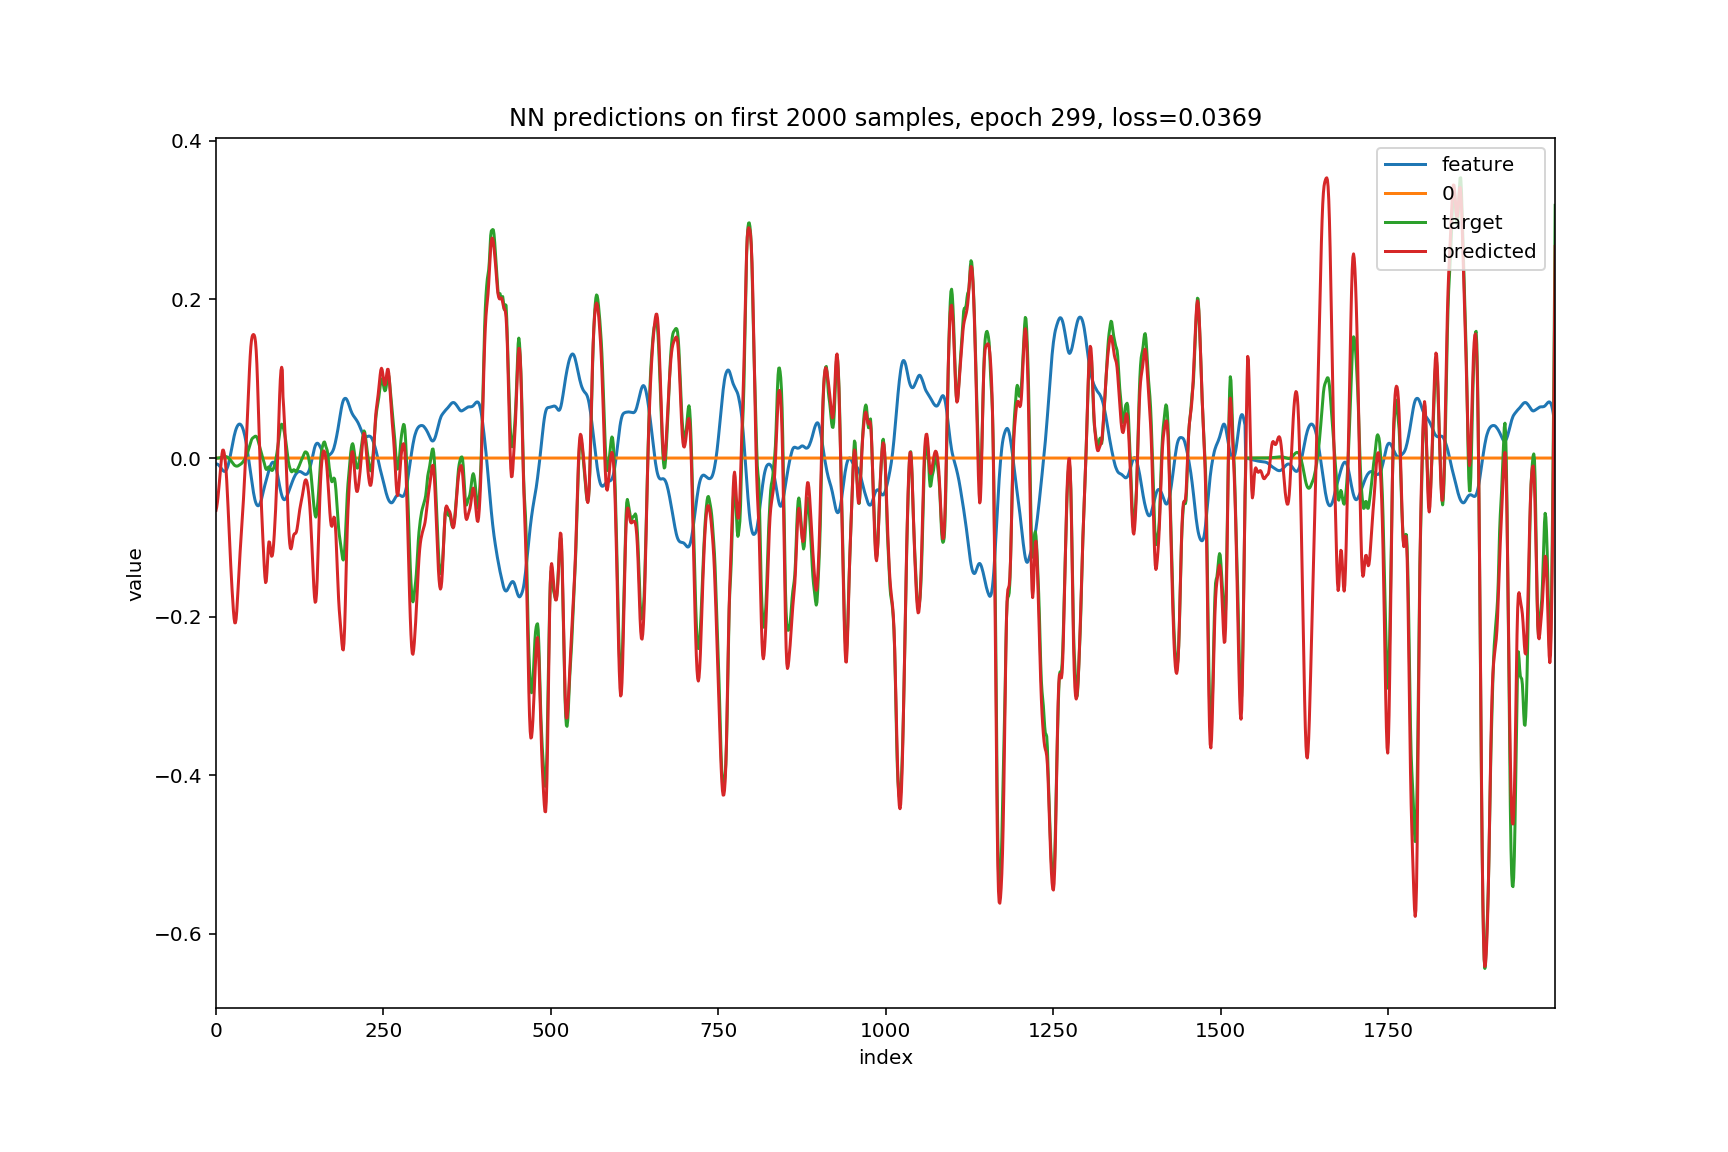

Epoch 1/300
4700/4700 [==============================] - 1s 203us/step - loss: 0.3511
Epoch 2/300
4700/4700 [==============================] - 0s 86us/step - loss: 0.3157
Epoch 3/300
4700/4700 [==============================] - 0s 86us/step - loss: 0.2883
Epoch 4/300
4700/4700 [==============================] - 0s 85us/step - loss: 0.2452
Epoch 5/300
4700/4700 [==============================] - 0s 85us/step - loss: 0.2103
Epoch 6/300
4700/4700 [==============================] - 0s 86us/step - loss: 0.2035
Epoch 7/300
4700/4700 [==============================] - 0s 90us/step - loss: 0.1990
Epoch 8/300
4700/4700 [==============================] - 0s 92us/step - loss: 0.2238
Epoch 9/300
4700/4700 [==============================] - 0s 93us/step - loss: 0.2065
Epoch 10/300
4700/4700 [==============================] - 0s 92us/step - loss: 0.2066
Epoch 11/300
4700/4700 [==============================] - 0s 92us/step - loss: 0.2069
Epoch 12/300
4700/4700 [==============================] - 0s 8

4700/4700 [==============================] - 0s 87us/step - loss: 0.0525
Epoch 191/300
4700/4700 [==============================] - 0s 87us/step - loss: 0.0485
Epoch 192/300
4700/4700 [==============================] - 0s 87us/step - loss: 0.0501
Epoch 193/300
4700/4700 [==============================] - 0s 89us/step - loss: 0.0530
Epoch 194/300
4700/4700 [==============================] - 0s 87us/step - loss: 0.0593
Epoch 195/300
4700/4700 [==============================] - 0s 88us/step - loss: 0.0606
Epoch 196/300
4700/4700 [==============================] - 0s 90us/step - loss: 0.0628
Epoch 197/300
4700/4700 [==============================] - 0s 88us/step - loss: 0.0602
Epoch 198/300
4700/4700 [==============================] - 0s 87us/step - loss: 0.0538
Epoch 199/300
4700/4700 [==============================] - 0s 88us/step - loss: 0.0508
Epoch 200/300
4700/4700 [==============================] - 0s 88us/step - loss: 0.0475
Epoch 201/300
4700/4700 [==============================] 

In [118]:
%matplotlib notebook

best_params = {
    'lr': 0.003,
    'n_samples': 4700,
    'n_units': 20,
    'batch_size': 100,
    'epochs': 300,
    'optimizer': keras.optimizers.Adam,
}


# model = load_model('saved_models/02_peak_comp_60_samples_180_params.h5')
model = create_model(best_params)

history, model = train_model(
    model,
    X_tr_s[:best_params['n_samples']],
    y_tr_s[:best_params['n_samples']],
    X_te_s[:best_params['n_samples']],
    y_te_s[:best_params['n_samples']],
    best_params,
    verbose_fit=1,
)

globals().update(locals())

In [127]:
MAGIC_OFFSET = 300

In [119]:
for layer in model.layers:
    weights = layer.get_weights() # list of numpy arrays
    print(weights)
    print('='*20)

[]
[array([[-5.3966969e-01, -1.1118026e+00, -6.5214407e-01,  9.0467781e-02,
        -7.2235221e-01,  4.8260581e-01, -6.0605955e-01, -1.3842185e-01,
        -2.6061434e-01,  8.8304833e-02,  1.1011589e-01,  2.7973908e-01,
         6.1423957e-01, -2.1717407e-01,  8.3118761e-01, -3.7578928e-01,
         6.8726093e-01, -6.4631248e-01,  1.5613700e+00,  5.1278162e-01,
        -4.3729395e-01, -3.6117285e-01,  6.4227974e-01,  4.5263919e-01,
         4.3617183e-01, -3.8658321e-02, -4.8670745e-01,  3.1484744e-01,
        -1.3100272e+00, -2.2906752e-01, -8.6041123e-01,  2.3242980e-01,
        -8.6732489e-01,  4.9291438e-01,  1.1274153e+00,  3.4383520e-01,
        -1.3006968e+00, -2.4181087e-01, -1.2096766e+00,  1.9387510e-01,
        -1.5844928e+00,  5.6355624e-03,  8.0028266e-01, -1.6290908e-01,
        -2.8568128e-01,  3.6738940e-02, -1.3105153e+00,  7.2539828e-05,
         4.2897728e-01,  7.4111395e-02,  1.2326586e+00,  7.1652941e-02,
         9.3506551e-01,  3.9850909e-02, -1.0747666e+00,  1.2

In [120]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (100, 64, 2)              0         
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (100, 64, 20)             1440      
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (100, 20)                 2520      
_________________________________________________________________
dense_2 (Dense)              (100, 1)                  21        
Total params: 3,981
Trainable params: 3,981
Non-trainable params: 0
_________________________________________________________________


In [121]:
# model.save('saved_models/02_peak_comp_60_samples_180_params.h5')

In [185]:
score = model.evaluate(X_te_s[:26300], y_te_s[:26300], verbose=0, batch_size=best_params['batch_size'])
score

0.13987795365513958

In [124]:
0.13085366091267628

0.13085366091267628

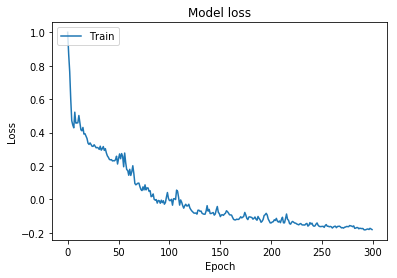

In [125]:
%matplotlib inline

from matplotlib import pyplot as plt

# Plot training & validation loss values
plt.plot(normalize(np.array(history.history['loss'])))
# plt.plot(normalize(np.array(history.history['val_loss'])))
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [107]:
len(X_te_f)

44000

In [108]:
predict(model, X_te_s[:100], batch_size=best_params['batch_size'])

array([ 0.42074916,  0.4188126 ,  0.41598648,  0.41277906,  0.40851912,
        0.4037629 ,  0.3983864 ,  0.3926526 ,  0.38597345,  0.37842116,
        0.3705096 ,  0.361632  ,  0.35192588,  0.34092385,  0.32864466,
        0.31568202,  0.30268106,  0.29069376,  0.28162712,  0.27519011,
        0.27254406,  0.27350447,  0.27352455,  0.26886126,  0.26181582,
        0.25466263,  0.24930623,  0.24505895,  0.24231344,  0.23949894,
        0.23742515,  0.23477152,  0.2312414 ,  0.22749475,  0.22364408,
        0.21994355,  0.2163364 ,  0.21182036,  0.2059817 ,  0.19874221,
        0.19102111,  0.18264833,  0.17472953,  0.16714606,  0.15959707,
        0.15110868,  0.14199403,  0.13170949,  0.12126684,  0.11032544,
        0.10013771,  0.09057215,  0.08067086,  0.0706026 ,  0.06075238,
        0.05121189,  0.04213148,  0.03372679,  0.0260295 ,  0.01935473,
        0.01373389,  0.00891228,  0.00369877, -0.00247651, -0.00914977,
       -0.01529282, -0.01987837, -0.02368823, -0.02737702, -0.03

In [109]:
print(X_tr_s[0][-1])

[-0.00759911]


0   -0.174752
1   -0.157108
2   -0.140616
3   -0.126550
4   -0.115485
dtype: float32


Text(0,0.5,'value')

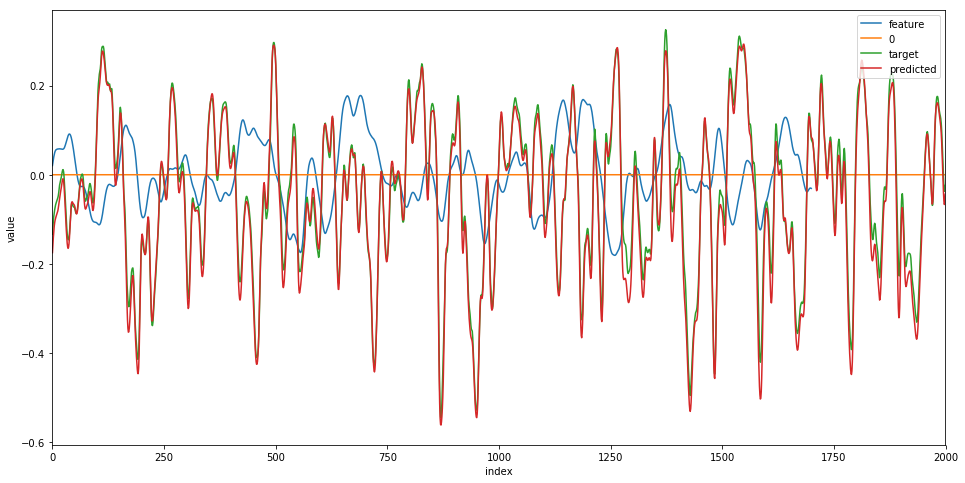

In [183]:
%matplotlib inline
from scipy.signal import savgol_filter

(fig, ax) = plt.subplots(figsize=(16, 8))

I = 2000
OFFSET = int(MAGIC_OFFSET)

X_to_test = X_tr_s
y_to_test = y_tr_s

feat = pd.Series((np.array(list(map(lambda row: row[-1][0], X_to_test[OFFSET:(I + OFFSET)]))))[OFFSET:])

feat.plot.line(ax=ax, label='feature')

targ = pd.Series(y_to_test[OFFSET:(I + OFFSET)])

pred = pd.Series(predict(model, X_to_test[:(I + OFFSET)], batch_size=best_params['batch_size'])[OFFSET:])
# pred = (pred * 3.2) + 0.001
pred = pred + 0.001

zeros = pd.Series(np.zeros(I))
zeros.plot.line(ax=ax, label='0')

targ.plot.line(ax=ax, label='target')

print(pred[:5])

pred.plot.line(ax=ax, label='predicted')
# pd.Series(savgol_filter(pred, 5, 3)).plot.line(ax=ax, label='savgol(predicted)')

# pd.Series(normalize(np.array(list(map(lambda w: w[-1], X_te_f[:I]))))).plot.line(ax=ax, label='feature')

ax.legend(loc="upper right")
ax.set_xlabel('index')
ax.set_ylabel('value')


## Time to evaluate performance

In [189]:
predictions = predict(model, X_tr_s[:(44000 * 3)], batch_size=best_params['batch_size'], verbose=1)
len(predictions), predictions[:10], np.max(predictions), np.min(predictions)

105500/105500 [==============================] - 3s 29us/step


(105500,
 array([ 0.00124932, -0.0011777 , -0.00466383, -0.00920963, -0.01273507,
        -0.01210583, -0.00779682, -0.00060855,  0.00921872,  0.02128481],
       dtype=float32),
 1.250766,
 -1.2015705)

In [193]:
predictions_n = np.clip((predictions / 1.25) * 0.8, -1.0, 1.0) * MAX_VALUE
len(predictions_n), predictions_n[:10], np.max(predictions_n), np.min(predictions_n)

(105500,
 array([  26.199339,  -24.697334,  -97.804535, -193.13399 , -267.06555 ,
        -253.86993 , -163.50623 ,  -12.761838,  193.3246  ,  446.3611  ],
       dtype=float32),
 26229.666,
 -25197.99)

In [194]:
wavfile.write('output/pred_out_gr_jump_head_v3.wav', source_fs, predictions)

In [195]:
len(predictions)

105500